<a href="https://colab.research.google.com/github/bdi2357/THE_WORLD_WORST_YOGA_STUDENT/blob/main/Pose_classification_(extended).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This Colab helps to create and validate a training set for the k-NN classifier described in the MediaPipe [Pose Classification](https://google.github.io/mediapipe/solutions/pose_classification.html) soultion, test it on an arbitrary video, export to a CSV and then use it in the [ML Kit sample app](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app).

# Step 0: Start Colab

Connect the Colab to hosted Python3 runtime (check top-right corner) and then install required dependencies.

In [ ]:

#
!pip install Pillow==5.3.0
!pip install matplotlib==3.1.3
!pip install numpy==1.19.3
!pip install opencv-python==4.5.1.48
!pip install tqdm==4.56.0
!pip install requests==2.25.1

!pip install mediapipe==0.8.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Codebase

## Commons

In [ ]:
from matplotlib import pyplot as plt


def show_image(img, figsize=(10, 10)):
  """Shows output PIL image."""
  plt.figure(figsize=figsize)
  plt.imshow(img)
  plt.show()

In [54]:
import os
os.listdir(".")

['.config',
 'fitness_poses_images_in.zip',
 'fitness_poses_csvs_out',
 'fitness_poses_images_in',
 'fitness_poses_images_out',
 'sample_data']

## Pose embedding

In [ ]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle

In [ ]:
#landmarks = result.pose_landmarks
def compute_important_angles(self,landmarks):
  """
  left_hip = landmarks[self._landmark_names.index('left_hip')]
  right_hip = landmarks[self._landmark_names.index('right_hip')]
  """
  #right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
  right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]

  #right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
  right_elbow = landmarks[self._landmark_names.index('right_elbow')]
  
  #right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]
  right_wrist = landmarks[self._landmark_names.index('right_wrist')]
              
  # Get coordinates
  #right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
  right_hip = landmarks[self._landmark_names.index('right_hip')]
  #right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
  right_knee = landmarks[self._landmark_names.index('right_knee')]
  #right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
  right_ankle = landmarks[self._landmark_names.index('right_ankle')]
  
  """
  computing angles
  """
  angle_right_side = calculate_angle(right_shoulder, right_elbow, right_wrist)          
  angle_right_knee = calculate_angle(right_hip, right_knee, right_ankle) #Knee joint angle
  angle_right_knee = round(angle_right_knee,2)
  
  angle_right_hip = calculate_angle(right_shoulder, right_hip, right_knee)
  angle_right_hip = round(angle_right_hip,2)
  
  right_hip_angle = 180-angle_right_knee
  right_knee_angle = 180-angle_right_knee
  return (right_hip_angle,right_knee_angle)

In [ ]:
if False:
  # Calculate angle
            angle = calculate_angle(shoulder, elbow, wrist)
            
            angle_knee = calculate_angle(hip, knee, ankle) #Knee joint angle
            angle_knee = round(angle_knee,2)
            
            angle_hip = calculate_angle(shoulder, hip, knee)
            angle_hip = round(angle_hip,2)
            
            hip_angle = 180-angle_hip
            knee_angle = 180-angle_knee
            
            
            angle_min.append(angle_knee)
            angle_min_hip.append(angle_hip)
            
            #print(angle_knee)
            # Visualize angle
            """cv2.putText(image, str(angle), 
                           tuple(np.multiply(elbow, [640, 480]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )"""
                       
                
            cv2.putText(image, str(angle_knee), 
                           tuple(np.multiply(knee, [1500, 800]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA
                                )
            
            cv2.putText(image, str(angle_hip), 
                           tuple(np.multiply(hip, [1500, 800]).astype(int)), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                                )


In [ ]:
class FullBodyPoseEmbedder(object):
  """Converts 3D pose landmarks into 3D embedding."""

  def __init__(self, torso_size_multiplier=2.5):
    # Multiplier to apply to the torso to get minimal body size.
    self._torso_size_multiplier = torso_size_multiplier

    # Names of the landmarks as they appear in the prediction.
    self._landmark_names = [
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',
        'left_elbow', 'right_elbow',
        'left_wrist', 'right_wrist',
        'left_pinky_1', 'right_pinky_1',
        'left_index_1', 'right_index_1',
        'left_thumb_2', 'right_thumb_2',
        'left_hip', 'right_hip',
        'left_knee', 'right_knee',
        'left_ankle', 'right_ankle',
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index',
    ]

  def __call__(self, landmarks):
    """Normalizes pose landmarks and converts to embedding
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances defined in `_get_pose_distance_embedding`.
    """
    assert landmarks.shape[0] == len(self._landmark_names), 'Unexpected number of landmarks: {}'.format(landmarks.shape[0])

    # Get pose landmarks.
    landmarks = np.copy(landmarks)

    # Normalize landmarks.
    landmarks = self._normalize_pose_landmarks(landmarks)

    # Get embedding.
    embedding = self._get_pose_distance_embedding(landmarks)

    return embedding

  def _normalize_pose_landmarks(self, landmarks):
    """Normalizes landmarks translation and scale."""
    landmarks = np.copy(landmarks)

    # Normalize translation.
    pose_center = self._get_pose_center(landmarks)
    landmarks -= pose_center

    # Normalize scale.
    pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
    landmarks /= pose_size
    # Multiplication by 100 is not required, but makes it eaasier to debug.
    landmarks *= 100

    return landmarks

  def _get_pose_angles(self,landmarks):
    """
    """
    
    return compute_important_angles(landmarks)


  def _get_pose_center(self, landmarks):
    """Calculates pose center as point between hips."""
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    center = (left_hip + right_hip) * 0.5
    return center

  def _get_pose_size(self, landmarks, torso_size_multiplier):
    """Calculates pose size.
    
    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # This approach uses only 2D landmarks to compute pose size.
    landmarks = landmarks[:, :2]

    # Hips center.
    left_hip = landmarks[self._landmark_names.index('left_hip')]
    right_hip = landmarks[self._landmark_names.index('right_hip')]
    hips = (left_hip + right_hip) * 0.5

    # Shoulders center.
    left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
    right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
    shoulders = (left_shoulder + right_shoulder) * 0.5

    # Torso size as the minimum body size.
    torso_size = np.linalg.norm(shoulders - hips)

    # Max dist to pose center.
    pose_center = self._get_pose_center(landmarks)
    max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

    return max(torso_size * torso_size_multiplier, max_dist)

  def _get_pose_distance_embedding(self, landmarks):
    """Converts pose landmarks into 3D embedding.

    We use several pairwise 3D distances to form pose embedding. All distances
    include X and Y components with sign. We differnt types of pairs to cover
    different pose classes. Feel free to remove some or add new.
    
    Args:
      landmarks - NumPy array with 3D landmarks of shape (N, 3).

    Result:
      Numpy array with pose embedding of shape (M, 3) where `M` is the number of
      pairwise distances.
    """
    embedding = np.array([
        # One joint.

        self._get_distance(
            self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
            self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

        self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

        # Two joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

        self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

        # Four joints.

        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Five joints.

        self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
        self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),
        
        self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
        self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

        # Cross body.

        self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
        self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

        self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
        self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

        # Body bent direction.

        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
        #     landmarks[self._landmark_names.index('left_hip')]),
        # self._get_distance(
        #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
        #     landmarks[self._landmark_names.index('right_hip')]),
    ])

    return embedding

  def _get_average_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return (lmk_from + lmk_to) * 0.5

  def _get_distance_by_names(self, landmarks, name_from, name_to):
    lmk_from = landmarks[self._landmark_names.index(name_from)]
    lmk_to = landmarks[self._landmark_names.index(name_to)]
    return self._get_distance(lmk_from, lmk_to)

  def _get_distance(self, lmk_from, lmk_to):
    return lmk_to - lmk_from

## Pose classification

In [ ]:
class PoseSample(object):

  def __init__(self, name, landmarks, class_name, embedding):
    self.name = name
    self.landmarks = landmarks
    self.class_name = class_name
    
    self.embedding = embedding


class PoseSampleOutlier(object):

  def __init__(self, sample, detected_class, all_classes):
    self.sample = sample
    self.detected_class = detected_class
    self.all_classes = all_classes

In [ ]:
import csv
import numpy as np
import os

class PoseClassifier(object):
  """Classifies pose landmarks."""

  def __init__(self,
               pose_samples_folder,
               pose_embedder,
               file_extension='csv',
               file_separator=',',
               n_landmarks=33,
               n_dimensions=3,
               top_n_by_max_distance=30,
               top_n_by_mean_distance=10,
               axes_weights=(1., 1., 0.2)):
    self._pose_embedder = pose_embedder
    self._n_landmarks = n_landmarks
    self._n_dimensions = n_dimensions
    self._top_n_by_max_distance = top_n_by_max_distance
    self._top_n_by_mean_distance = top_n_by_mean_distance
    self._axes_weights = axes_weights

    self._pose_samples = self._load_pose_samples(pose_samples_folder,
                                                 file_extension,
                                                 file_separator,
                                                 n_landmarks,
                                                 n_dimensions,
                                                 pose_embedder)

  def _load_pose_samples(self,
                         pose_samples_folder,
                         file_extension,
                         file_separator,
                         n_landmarks,
                         n_dimensions,
                         pose_embedder):
    """Loads pose samples from a given folder.
    
    Required folder structure:
      neutral_standing.csv
      pushups_down.csv
      pushups_up.csv
      squats_down.csv
      ...

    Required CSV structure:
      sample_00001,x1,y1,z1,x2,y2,z2,....
      sample_00002,x1,y1,z1,x2,y2,z2,....
      ...
    """
    # Each file in the folder represents one pose class.
    file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

    pose_samples = []
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]
      
      # Parse CSV.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=file_separator)
        for row in csv_reader:
          assert len(row) == n_landmarks * n_dimensions + 1, 'Wrong number of values: {}'.format(len(row))
          landmarks = np.array(row[1:], np.float32).reshape([n_landmarks, n_dimensions])
          pose_samples.append(PoseSample(
              name=row[0],
              landmarks=landmarks,
              class_name=class_name,
              embedding=pose_embedder(landmarks),
          ))

    return pose_samples

  def find_pose_sample_outliers(self):
    """Classifies each sample against the entire database."""
    # Find outliers in target poses
    outliers = []
    for sample in self._pose_samples:
      # Find nearest poses for the target one.
      pose_landmarks = sample.landmarks.copy()
      pose_classification = self.__call__(pose_landmarks)
      class_names = [class_name for class_name, count in pose_classification.items() if count == max(pose_classification.values())]

      # Sample is an outlier if nearest poses have different class or more than
      # one pose class is detected as nearest.
      #if sample.class_name not in class_names or len(class_names) != 1:
      if sample.class_name not in class_names :
        outliers.append(PoseSampleOutlier(sample, class_names, pose_classification))

    return outliers

  def __call__(self, pose_landmarks):
    """Classifies given pose.

    Classification is done in two stages:
      * First we pick top-N samples by MAX distance. It allows to remove samples
        that are almost the same as given pose, but has few joints bent in the
        other direction.
      * Then we pick top-N samples by MEAN distance. After outliers are removed
        on a previous step, we can pick samples that are closes on average.
    
    Args:
      pose_landmarks: NumPy array with 3D landmarks of shape (N, 3).

    Returns:
      Dictionary with count of nearest pose samples from the database. Sample:
        {
          'pushups_down': 8,
          'pushups_up': 2,
        }
    """
    # Check that provided and target poses have the same shape.
    assert pose_landmarks.shape == (self._n_landmarks, self._n_dimensions), 'Unexpected shape: {}'.format(pose_landmarks.shape)

    # Get given pose embedding.
    pose_embedding = self._pose_embedder(pose_landmarks)
    flipped_pose_embedding = self._pose_embedder(pose_landmarks * np.array([-1, 1, 1]))

    # Filter by max distance.
    #
    # That helps to remove outliers - poses that are almost the same as the
    # given one, but has one joint bent into another direction and actually
    # represnt a different pose class.
    max_dist_heap = []
    for sample_idx, sample in enumerate(self._pose_samples):
      max_dist = min(
          np.max(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.max(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      max_dist_heap.append([max_dist, sample_idx])

    max_dist_heap = sorted(max_dist_heap, key=lambda x: x[0])
    max_dist_heap = max_dist_heap[:self._top_n_by_max_distance]

    # Filter by mean distance.
    #
    # After removing outliers we can find the nearest pose by mean distance.
    mean_dist_heap = []
    for _, sample_idx in max_dist_heap:
      sample = self._pose_samples[sample_idx]
      mean_dist = min(
          np.mean(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
          np.mean(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
      )
      mean_dist_heap.append([mean_dist, sample_idx])

    mean_dist_heap = sorted(mean_dist_heap, key=lambda x: x[0])
    mean_dist_heap = mean_dist_heap[:self._top_n_by_mean_distance]

    # Collect results into map: (class_name -> n_samples)
    class_names = [self._pose_samples[sample_idx].class_name for _, sample_idx in mean_dist_heap]
    result = {class_name: class_names.count(class_name) for class_name in set(class_names)}

    return result

## Classification smoothing

In [ ]:
class EMADictSmoothing(object):
  """Smoothes pose classification."""

  def __init__(self, window_size=10, alpha=0.2):
    self._window_size = window_size
    self._alpha = alpha

    self._data_in_window = []

  def __call__(self, data):
    """Smoothes given pose classification.

    Smoothing is done by computing Exponential Moving Average for every pose
    class observed in the given time window. Missed pose classes arre replaced
    with 0.
    
    Args:
      data: Dictionary with pose classification. Sample:
          {
            'pushups_down': 8,
            'pushups_up': 2,
          }

    Result:
      Dictionary in the same format but with smoothed and float instead of
      integer values. Sample:
        {
          'pushups_down': 8.3,
          'pushups_up': 1.7,
        }
    """
    # Add new data to the beginning of the window for simpler code.
    self._data_in_window.insert(0, data)
    self._data_in_window = self._data_in_window[:self._window_size]

    # Get all keys.
    keys = set([key for data in self._data_in_window for key, _ in data.items()])

    # Get smoothed values.
    smoothed_data = dict()
    for key in keys:
      factor = 1.0
      top_sum = 0.0
      bottom_sum = 0.0
      for data in self._data_in_window:
        value = data[key] if key in data else 0.0

        top_sum += factor * value
        bottom_sum += factor

        # Update factor.
        factor *= (1.0 - self._alpha)

      smoothed_data[key] = top_sum / bottom_sum

    return smoothed_data

## Repetition counter

In [ ]:
class RepetitionCounter(object):
  """Counts number of repetitions of given target pose class."""

  def __init__(self, class_name, enter_threshold=6, exit_threshold=4):
    self._class_name = class_name

    # If pose counter passes given threshold, then we enter the pose.
    self._enter_threshold = enter_threshold
    self._exit_threshold = exit_threshold

    # Either we are in given pose or not.
    self._pose_entered = False

    # Number of times we exited the pose.
    self._n_repeats = 0

  @property
  def n_repeats(self):
    return self._n_repeats

  def __call__(self, pose_classification):
    """Counts number of repetitions happend until given frame.

    We use two thresholds. First you need to go above the higher one to enter
    the pose, and then you need to go below the lower one to exit it. Difference
    between the thresholds makes it stable to prediction jittering (which will
    cause wrong counts in case of having only one threshold).
    
    Args:
      pose_classification: Pose classification dictionary on current frame.
        Sample:
          {
            'pushups_down': 8.3,
            'pushups_up': 1.7,
          }

    Returns:
      Integer counter of repetitions.
    """
    # Get pose confidence.
    pose_confidence = 0.0
    if self._class_name in pose_classification:
      pose_confidence = pose_classification[self._class_name]

    # On the very first frame or if we were out of the pose, just check if we
    # entered it on this frame and update the state.
    if not self._pose_entered:
      self._pose_entered = pose_confidence > self._enter_threshold
      return self._n_repeats

    # If we were in the pose and are exiting it, then increase the counter and
    # update the state.
    if pose_confidence < self._exit_threshold:
      self._n_repeats += 1
      self._pose_entered = False

    return self._n_repeats

## Classification visualizer

In [ ]:
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests

class PoseClassificationVisualizer(object):
  """Keeps track of claassifcations for every frame and renders them."""

  def __init__(self,
               class_name,
               plot_location_x=0.05,
               plot_location_y=0.05,
               plot_max_width=0.4,
               plot_max_height=0.4,
               plot_figsize=(9, 4),
               plot_x_max=None,
               plot_y_max=None,
               counter_location_x=0.85,
               counter_location_y=0.05,
               counter_font_path='https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true',
               counter_font_color='red',
               counter_font_size=0.15):
    self._class_name = class_name
    self._plot_location_x = plot_location_x
    self._plot_location_y = plot_location_y
    self._plot_max_width = plot_max_width
    self._plot_max_height = plot_max_height
    self._plot_figsize = plot_figsize
    self._plot_x_max = plot_x_max
    self._plot_y_max = plot_y_max
    self._counter_location_x = counter_location_x
    self._counter_location_y = counter_location_y
    self._counter_font_path = counter_font_path
    self._counter_font_color = counter_font_color
    self._counter_font_size = counter_font_size

    self._counter_font = None

    self._pose_classification_history = []
    self._pose_classification_filtered_history = []

  def __call__(self,
               frame,
               pose_classification,
               pose_classification_filtered,
               repetitions_count):
    """Renders pose classifcation and counter until given frame."""
    # Extend classification history.
    self._pose_classification_history.append(pose_classification)
    self._pose_classification_filtered_history.append(pose_classification_filtered)

    # Output frame with classification plot and counter.
    output_img = Image.fromarray(frame)

    output_width = output_img.size[0]
    output_height = output_img.size[1]

    # Draw the plot.
    img = self._plot_classification_history(output_width, output_height)
    img.thumbnail((int(output_width * self._plot_max_width),
                   int(output_height * self._plot_max_height)),
                  Image.ANTIALIAS)
    output_img.paste(img,
                     (int(output_width * self._plot_location_x),
                      int(output_height * self._plot_location_y)))

    # Draw the count.
    output_img_draw = ImageDraw.Draw(output_img)
    if self._counter_font is None:
      font_size = int(output_height * self._counter_font_size)
      font_request = requests.get(self._counter_font_path, allow_redirects=True)
      self._counter_font = ImageFont.truetype(io.BytesIO(font_request.content), size=font_size)
    output_img_draw.text((output_width * self._counter_location_x,
                          output_height * self._counter_location_y),
                         str(repetitions_count),
                         font=self._counter_font,
                         fill=self._counter_font_color)

    return output_img

  def _plot_classification_history(self, output_width, output_height):
    fig = plt.figure(figsize=self._plot_figsize)

    for classification_history in [self._pose_classification_history,
                                   self._pose_classification_filtered_history]:
      y = []
      for classification in classification_history:
        if classification is None:
          y.append(None)
        elif self._class_name in classification:
          y.append(classification[self._class_name])
        else:
          y.append(0)
      plt.plot(y, linewidth=7)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Frame')
    plt.ylabel('Confidence')
    plt.title('Classification history for `{}`'.format(self._class_name))
    plt.legend(loc='upper right')

    if self._plot_y_max is not None:
      plt.ylim(top=self._plot_y_max)
    if self._plot_x_max is not None:
      plt.xlim(right=self._plot_x_max)

    # Convert plot to image.
    buf = io.BytesIO()
    dpi = min(
        output_width * self._plot_max_width / float(self._plot_figsize[0]),
        output_height * self._plot_max_height / float(self._plot_figsize[1]))
    fig.savefig(buf, dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    return img

In [ ]:
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests

class PoseClassificationVisualizer2(object):
  """Keeps track of claassifcations for every frame and renders them."""

  def __init__(self,
               class_name,
               plot_location_x=0.05,
               plot_location_y=0.05,
               plot_max_width=0.4,
               plot_max_height=0.4,
               plot_figsize=(9, 4),
               plot_x_max=None,
               plot_y_max=None,
               counter_location_x=0.65,
               counter_location_y=0.05,
               counter_font_path='https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true',
               counter_font_color='red',
               counter_font_size=0.05):
    self._class_name = class_name
    self._plot_location_x = plot_location_x
    self._plot_location_y = plot_location_y
    self._plot_max_width = plot_max_width
    self._plot_max_height = plot_max_height
    self._plot_figsize = plot_figsize
    self._plot_x_max = plot_x_max
    self._plot_y_max = plot_y_max
    self._counter_location_x = counter_location_x
    self._counter_location_y = counter_location_y
    self._counter_font_path = counter_font_path
    self._counter_font_color = counter_font_color
    self._counter_font_size = counter_font_size

    self._counter_font = None

    self._pose_classification_history = []
    self._pose_classification_filtered_history = []

  def __call__(self,
               frame,
               pose_classification,
               pose_classification_filtered,
               asana):
    """Renders pose classifcation and counter until given frame."""
    # Extend classification history.
    self._pose_classification_history.append(pose_classification)
    self._pose_classification_filtered_history.append(pose_classification_filtered)

    # Output frame with classification plot and counter.
    output_img = Image.fromarray(frame)

    output_width = output_img.size[0]
    output_height = output_img.size[1]

    # Draw the plot.
    """
    img = self._plot_classification_history(output_width, output_height)
    img.thumbnail((int(output_width * self._plot_max_width),
                   int(output_height * self._plot_max_height)),
                  Image.ANTIALIAS)
    output_img.paste(img,
                     (int(output_width * self._plot_location_x),
                      int(output_height * self._plot_location_y)))
    """

    # Draw the count.
    output_img_draw = ImageDraw.Draw(output_img)
    if self._counter_font is None:
      font_size = int(output_height * self._counter_font_size)
      font_request = requests.get(self._counter_font_path, allow_redirects=True)
      self._counter_font = ImageFont.truetype(io.BytesIO(font_request.content), size=font_size)
    output_img_draw.text((output_width * self._counter_location_x,
                          output_height * self._counter_location_y),
                         str(asana),
                         font=self._counter_font,
                         fill=self._counter_font_color)

    return output_img

  def _plot_classification_history(self, output_width, output_height):
    fig = plt.figure(figsize=self._plot_figsize)

    for classification_history in [self._pose_classification_history,
                                   self._pose_classification_filtered_history]:
      y = []
      for classification in classification_history:
        if classification is None:
          y.append(None)
        elif self._class_name in classification:
          y.append(classification[self._class_name])
        else:
          y.append(0)
      plt.plot(y, linewidth=7)

    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Frame')
    plt.ylabel('Confidence')
    plt.title('Classification history for `{}`'.format(self._class_name))
    plt.legend(loc='upper right')

    if self._plot_y_max is not None:
      plt.ylim(top=self._plot_y_max)
    if self._plot_x_max is not None:
      plt.xlim(right=self._plot_x_max)

    # Convert plot to image.
    buf = io.BytesIO()
    dpi = min(
        output_width * self._plot_max_width / float(self._plot_figsize[0]),
        output_height * self._plot_max_height / float(self._plot_figsize[1]))
    fig.savefig(buf, dpi=dpi)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    return img

## Bootstrap helper

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


class BootstrapHelper(object):
  """Helps to bootstrap images and filter pose samples for classification."""

  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_folder):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_folder = csvs_out_folder

    # Get list of pose classes and print image statistics.
    self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])
    
  def bootstrap(self, per_pose_class_limit=None):
    """Bootstraps images in a given folder.
    
    Required image in folder (same use for image out folder):
      pushups_up/
        image_001.jpg
        image_002.jpg
        ...
      pushups_down/
        image_001.jpg
        image_002.jpg
        ...
      ...

    Produced CSVs out folder:
      pushups_up.csv
      pushups_down.csv

    Produced CSV structure with pose 3D landmarks:
      sample_00001,x1,y1,z1,x2,y2,z2,....
      sample_00002,x1,y1,z1,x2,y2,z2,....
    """
    # Create output folder for CVSs.
    if not os.path.exists(self._csvs_out_folder):
      os.makedirs(self._csvs_out_folder)

    for pose_class_name in self._pose_class_names:
      print('Bootstrapping ', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      with open(csv_out_path, 'w') as csv_out_file:
        print(csv_out_path)
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        # Get list of images.
        image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        # Bootstrap every image.
        for image_name in tqdm.tqdm(image_names):
          # Load image.
          print(image_name)
          input_frame = cv2.imread(os.path.join(images_in_folder, image_name))
          input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

          # Initialize fresh pose tracker and run it.
          with mp_pose.Pose(upper_body_only=False) as pose_tracker:
            result = pose_tracker.process(image=input_frame)
            pose_landmarks = result.pose_landmarks

          # Save image with pose prediction (if pose was detected).
          output_frame = input_frame.copy()
          if pose_landmarks is not None:
            mp_drawing.draw_landmarks(
                image=output_frame,
                landmark_list=pose_landmarks,
                connections=mp_pose.POSE_CONNECTIONS)
          output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
          
          # Save landmarks if pose was detected.
          if pose_landmarks is not None:
            # Get landmarks.
            frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
            pose_landmarks = np.array(
                [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                 for lmk in pose_landmarks.landmark],
                dtype=np.float32)
            assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)
            csv_out_writer.writerow([image_name] + pose_landmarks.flatten().astype(np.str).tolist())

          # Draw XZ projection and concatenate with the image.
          projection_xz = self._draw_xz_projection(
              output_frame=output_frame, pose_landmarks=pose_landmarks)
          output_frame = np.concatenate((output_frame, projection_xz), axis=1)

  def _draw_xz_projection(self, output_frame, pose_landmarks, r=0.5, color='red'):
    frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
    img = Image.new('RGB', (frame_width, frame_height), color='white')

    if pose_landmarks is None:
      return np.asarray(img)

    # Scale radius according to the image width.
    r *= frame_width * 0.01

    draw = ImageDraw.Draw(img)
    for idx_1, idx_2 in mp_pose.POSE_CONNECTIONS:
      # Flip Z and move hips center to the center of the image.
      x1, y1, z1 = pose_landmarks[idx_1] * [1, 1, -1] + [0, 0, frame_height * 0.5]
      x2, y2, z2 = pose_landmarks[idx_2] * [1, 1, -1] + [0, 0, frame_height * 0.5]

      draw.ellipse([x1 - r, z1 - r, x1 + r, z1 + r], fill=color)
      draw.ellipse([x2 - r, z2 - r, x2 + r, z2 + r], fill=color)
      draw.line([x1, z1, x2, z2], width=int(r), fill=color)

    return np.asarray(img)

  def align_images_and_csvs(self, print_removed_items=False):
    """Makes sure that image folders and CSVs have the same sample.
    
    Leaves only intersetion of samples in both image folders and CSVs.
    """
    for pose_class_name in self._pose_class_names:
      # Paths for the pose class.
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')

      # Read CSV into memory.
      rows = []
      with open(csv_out_path) as csv_out_file:
        csv_out_reader = csv.reader(csv_out_file, delimiter=',')
        for row in csv_out_reader:
          rows.append(row)

      # Image names left in CSV.
      image_names_in_csv = []

      # Re-write the CSV removing lines without corresponding images.
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        for row in rows:
          image_name = row[0]
          image_path = os.path.join(images_out_folder, image_name)
          if os.path.exists(image_path):
            image_names_in_csv.append(image_name)
            csv_out_writer.writerow(row)
          elif print_removed_items:
            print('Removed image from CSV: ', image_path)

      # Remove images without corresponding line in CSV.
      for image_name in os.listdir(images_out_folder):
        if image_name not in image_names_in_csv:
          image_path = os.path.join(images_out_folder, image_name)
          os.remove(image_path)
          if print_removed_items:
            print('Removed image from folder: ', image_path)

  def analyze_outliers(self, outliers):
    """Classifies each sample agains all other to find outliers.
    
    If sample is classified differrrently than the original class - it sould
    either be deleted or more similar samples should be aadded.
    """
    for outlier in outliers:
      image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)

      print('Outlier')
      print('  sample path =    ', image_path)
      print('  sample class =   ', outlier.sample.class_name)
      print('  detected class = ', outlier.detected_class)
      print('  all classes =    ', outlier.all_classes)

      img = cv2.imread(image_path)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      show_image(img, figsize=(20, 20))

  def remove_outliers(self, outliers):
    """Removes outliers from the image folders."""
    for outlier in outliers:
      image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)
      os.remove(image_path)

  def print_images_in_statistics(self):
    """Prints statistics from the input image folder."""
    self._print_images_statistics(self._images_in_folder, self._pose_class_names)

  def print_images_out_statistics(self):
    """Prints statistics from the output image folder."""
    self._print_images_statistics(self._images_out_folder, self._pose_class_names)

  def _print_images_statistics(self, images_folder, pose_class_names):
    print('Number of images per pose class:')
    for pose_class_name in pose_class_names:
      n_images = len([
          n for n in os.listdir(os.path.join(images_folder, pose_class_name))
          if not n.startswith('.')])
      print('  {}: {}'.format(pose_class_name, n_images))

# Step 1: Build classifier

## Upload image samples

Locally create a folder named `fitness_poses_images_in` with image samples.

Images should repesent terminal states of desired pose classes. I.e. if you want to classify push-up provide iamges for two classes: when person is up, and when person is down.

There should be about a few hundred samples per class covering different camera angles, environment conditions, body shapes, and exercise variations to build a good classifier.

Required structure of the images_in_folder:
```
fitness_poses_images_in/
  pushups_up/
    image_001.jpg
    image_002.jpg
    ...
  pushups_down/
    image_001.jpg
    image_002.jpg
    ...
  ...
```

Zip the `fitness_poses_images_in` folder:
```
zip -r fitness_poses_images_in.zip fitness_poses_images_in
```

And run the code below to upload it to the Colab runtime

In [ ]:
os.system("rm -r fitness_poses_images_in*")
os.system("rm view?usp=sharing")

0

In [ ]:
os.listdir('.')

['.config', 'sample_data']

In [ ]:
os.system("rm -r fitness_poses*")

256

In [ ]:
os.listdir('.')

['.config', 'sample_data']

In [ ]:
!gdown  1ezH5fLcAwzBznmUu0_v8fcQJ7hpZV-kO

Downloading...
From: https://drive.google.com/uc?id=1ezH5fLcAwzBznmUu0_v8fcQJ7hpZV-kO
To: /content/fitness_poses_images_in.zip
100% 1.77M/1.77M [00:00<00:00, 144MB/s]


In [ ]:
os.listdir(".")

['.config', 'fitness_poses_images_in.zip', 'sample_data']

In [ ]:
os.system("mv view?usp=sharing fitness_poses_images_in.zip")

0

In [ ]:
from google.colab import files
import os

uploaded = files.upload()
os.listdir('.')

KeyboardInterrupt: ignored

Unzip the archive:

In [ ]:
import zipfile
import io

#zf = zipfile.ZipFile(io.BytesIO(uploaded['fitness_poses_images_in.zip']), "r")
zf = zipfile.ZipFile('fitness_poses_images_in.zip', "r")
zf.extractall()
os.listdir('.')

['.config',
 'fitness_poses_images_in.zip',
 'fitness_poses_images_in',
 'sample_data']

In [ ]:
os.listdir(".")

['.config',
 'fitness_poses_images_in.zip',
 'fitness_poses_images_in',
 'sample_data']

## Bootstrap images

In [ ]:
# Required structure of the images_in_folder:
#
#   fitness_poses_images_in/
#     pushups_up/
#       image_001.jpg
#       image_002.jpg
#       ...
#     pushups_down/
#       image_001.jpg
#       image_002.jpg
#       ...
#     ...
bootstrap_images_in_folder = 'fitness_poses_images_in'

# Output folders for bootstrapped images and CSVs.
bootstrap_images_out_folder = 'fitness_poses_images_out'
bootstrap_csvs_out_folder = 'fitness_poses_csvs_out'

In [ ]:
# Initialize helper.
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [ ]:
# Check how many pose classes and images for them are available.
bootstrap_helper.print_images_in_statistics()

Number of images per pose class:
  AdhoMukhaSvanasana: 21
  Tadasana: 10
  Trikonasana: 17
  UrdhvaMukhaShvanasana: 10
  Uttanasana: 10
  UtthitaParsvakonasana: 22
  VirabhadrasanaI: 28
  VirabhadrasanaII: 17
  VirabhadrasanaIII: 14
  Vrikshasana: 16


In [ ]:
# Bootstrap all images.
# Set limit to some small number for debug.
bootstrap_helper.bootstrap(per_pose_class_limit=None)

Bootstrapping  AdhoMukhaSvanasana
  0%|          | 0/21 [00:00<?, ?it/s]

fitness_poses_csvs_out/AdhoMukhaSvanasana.csv
AdhoMukhaSvanasana1.jpeg


 10%|▉         | 2/21 [00:00<00:03,  5.72it/s]

AdhoMukhaSvanasana10.jpeg
AdhoMukhaSvanasana11.jpeg


 19%|█▉        | 4/21 [00:00<00:02,  6.15it/s]

AdhoMukhaSvanasana2.jpeg
AdhoMukhaSvanasana3.jpeg


 29%|██▊       | 6/21 [00:00<00:02,  6.48it/s]

AdhoMukhaSvanasana4.jpeg
AdhoMukhaSvanasana5.jpeg


 38%|███▊      | 8/21 [00:01<00:01,  6.60it/s]

AdhoMukhaSvanasana6.jpeg
AdhoMukhaSvanasana7.jpeg


 48%|████▊     | 10/21 [00:01<00:01,  6.41it/s]

AdhoMukhaSvanasana8.jpeg
AdhoMukhaSvanasana9.jpeg


 57%|█████▋    | 12/21 [00:01<00:01,  6.60it/s]

adha1.jpeg
adha10.jpeg


 67%|██████▋   | 14/21 [00:02<00:01,  6.54it/s]

adha2.jpeg
adha3.jpeg


 76%|███████▌  | 16/21 [00:02<00:00,  6.55it/s]

adha4.jpeg
adha5.jpeg


 86%|████████▌ | 18/21 [00:02<00:00,  6.49it/s]

adha6.jpeg
adha7.jpeg


 95%|█████████▌| 20/21 [00:03<00:00,  6.65it/s]

adha8.jpeg
adha9.jpeg


100%|██████████| 21/21 [00:03<00:00,  6.45it/s]
Bootstrapping  Tadasana
 10%|█         | 1/10 [00:00<00:01,  6.60it/s]

fitness_poses_csvs_out/Tadasana.csv
tadasana.jpeg
tadasana10.jpeg


 30%|███       | 3/10 [00:00<00:01,  6.41it/s]

tadasana2.jpeg
tadasana3.jpeg


 50%|█████     | 5/10 [00:00<00:00,  6.65it/s]

tadasana4.jpeg
tadasana5.jpeg


 70%|███████   | 7/10 [00:01<00:00,  6.41it/s]

tadasana6.jpeg
tadasana7.jpeg


 90%|█████████ | 9/10 [00:01<00:00,  6.36it/s]

tadasana8.jpeg
tadasana9.jpeg


100%|██████████| 10/10 [00:01<00:00,  6.64it/s]
Bootstrapping  Trikonasana
  6%|▌         | 1/17 [00:00<00:02,  6.69it/s]

fitness_poses_csvs_out/Trikonasana.csv
Trikonasana1.jpeg
Trikonasana10.jpeg


 18%|█▊        | 3/17 [00:00<00:02,  6.57it/s]

Trikonasana11.jpeg
Trikonasana12.jpeg


 29%|██▉       | 5/17 [00:00<00:01,  6.69it/s]

Trikonasana13.jpeg
Trikonasana14.jpeg


 41%|████      | 7/17 [00:01<00:01,  6.49it/s]

Trikonasana15.jpeg
Trikonasana16.jpeg


 53%|█████▎    | 9/17 [00:01<00:01,  6.57it/s]

Trikonasana17.jpeg
Trikonasana18.jpeg


 65%|██████▍   | 11/17 [00:01<00:00,  6.62it/s]

Trikonasana2.jpeg
Trikonasana3.jpeg


 76%|███████▋  | 13/17 [00:01<00:00,  6.41it/s]

Trikonasana5.jpeg
Trikonasana6.jpeg


 88%|████████▊ | 15/17 [00:02<00:00,  6.65it/s]

Trikonasana7.jpeg
Trikonasana8.jpeg


100%|██████████| 17/17 [00:02<00:00,  6.57it/s]
Bootstrapping  UrdhvaMukhaShvanasana
  0%|          | 0/10 [00:00<?, ?it/s]

Trikonasana9.jpeg
fitness_poses_csvs_out/UrdhvaMukhaShvanasana.csv
urdhva1.jpeg


 20%|██        | 2/10 [00:00<00:01,  6.58it/s]

urdhva10.jpeg
urdhva2.jpeg


 40%|████      | 4/10 [00:00<00:00,  6.53it/s]

urdhva3.jpeg
urdhva4.jpeg


 60%|██████    | 6/10 [00:00<00:00,  6.68it/s]

urdhva5.jpeg
urdhva6.jpeg


 90%|█████████ | 9/10 [00:01<00:00,  6.50it/s]

urdhva7.jpeg
urdhva8.jpeg
urdhva9.jpeg


100%|██████████| 10/10 [00:01<00:00,  6.56it/s]
Bootstrapping  Uttanasana
 10%|█         | 1/10 [00:00<00:01,  6.87it/s]

fitness_poses_csvs_out/Uttanasana.csv
uttanasana1.jpeg
uttanasana10.jpeg


 30%|███       | 3/10 [00:00<00:01,  6.70it/s]

uttanasana2.jpeg
uttanasana3.jpeg


 50%|█████     | 5/10 [00:00<00:00,  6.62it/s]

uttanasana4.jpeg
uttanasana5.jpeg


 80%|████████  | 8/10 [00:01<00:00,  6.60it/s]

uttanasana6.jpeg
uttanasana7.jpeg
uttanasana8.jpeg


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]
Bootstrapping  UtthitaParsvakonasana
  0%|          | 0/22 [00:00<?, ?it/s]

uttanasana9.jpeg
fitness_poses_csvs_out/UtthitaParsvakonasana.csv
utthita_parsvakonasana1.jpeg


  9%|▉         | 2/22 [00:00<00:03,  6.61it/s]

utthita_parsvakonasana10.jpeg
utthita_parsvakonasana11.jpeg


 18%|█▊        | 4/22 [00:00<00:02,  6.57it/s]

utthita_parsvakonasana12.jpeg
utthita_parsvakonasana13.jpeg


 27%|██▋       | 6/22 [00:00<00:02,  6.57it/s]

utthita_parsvakonasana14.jpeg
utthita_parsvakonasana15.jpeg


 36%|███▋      | 8/22 [00:01<00:02,  6.46it/s]

utthita_parsvakonasana16.jpeg
utthita_parsvakonasana17.jpeg


 45%|████▌     | 10/22 [00:01<00:01,  6.65it/s]

utthita_parsvakonasana18.jpeg
utthita_parsvakonasana2.jpeg


 59%|█████▉    | 13/22 [00:01<00:01,  6.85it/s]

utthita_parsvakonasana22.jpeg
utthita_parsvakonasana23.jpeg
utthita_parsvakonasana24.jpeg


 68%|██████▊   | 15/22 [00:02<00:01,  6.67it/s]

utthita_parsvakonasana25.jpeg
utthita_parsvakonasana3.jpeg


 77%|███████▋  | 17/22 [00:02<00:00,  6.76it/s]

utthita_parsvakonasana4.jpeg
utthita_parsvakonasana5.jpeg


 86%|████████▋ | 19/22 [00:02<00:00,  6.79it/s]

utthita_parsvakonasana6.jpeg
utthita_parsvakonasana7.jpeg


 95%|█████████▌| 21/22 [00:03<00:00,  6.83it/s]

utthita_parsvakonasana8.jpeg
utthita_parsvakonasana9.jpeg


100%|██████████| 22/22 [00:03<00:00,  6.66it/s]
Bootstrapping  VirabhadrasanaI
  4%|▎         | 1/28 [00:00<00:04,  6.04it/s]

fitness_poses_csvs_out/VirabhadrasanaI.csv
virabhadrasanaI.jpeg
virabhadrasanaI10.jpeg


 11%|█         | 3/28 [00:00<00:03,  6.75it/s]

virabhadrasanaI11.jpeg
virabhadrasanaI12.jpeg


 18%|█▊        | 5/28 [00:00<00:03,  6.82it/s]

virabhadrasanaI13.jpeg
virabhadrasanaI14.jpeg


 25%|██▌       | 7/28 [00:01<00:03,  6.53it/s]

virabhadrasanaI15.jpeg
virabhadrasanaI16.jpeg


 32%|███▏      | 9/28 [00:01<00:02,  6.53it/s]

virabhadrasanaI17.jpeg
virabhadrasanaI18.jpeg


 39%|███▉      | 11/28 [00:01<00:02,  6.54it/s]

virabhadrasanaI19.jpeg
virabhadrasanaI2.jpeg


 46%|████▋     | 13/28 [00:01<00:02,  6.56it/s]

virabhadrasanaI20.jpeg
virabhadrasanaI21.jpeg


 54%|█████▎    | 15/28 [00:02<00:01,  6.53it/s]

virabhadrasanaI22.jpeg
virabhadrasanaI23.jpeg


 61%|██████    | 17/28 [00:02<00:01,  6.59it/s]

virabhadrasanaI24.jpeg
virabhadrasanaI25.jpeg


 68%|██████▊   | 19/28 [00:02<00:01,  6.65it/s]

virabhadrasanaI26.jpeg
virabhadrasanaI27.jpeg


 75%|███████▌  | 21/28 [00:03<00:01,  6.56it/s]

virabhadrasanaI3.jpeg
virabhadrasanaI4.jpeg


 82%|████████▏ | 23/28 [00:03<00:00,  6.71it/s]

virabhadrasanaI5.jpeg
virabhadrasanaI6.jpeg


 89%|████████▉ | 25/28 [00:03<00:00,  6.75it/s]

virabhadrasanaI7.jpeg
virabhadrasanaI8.jpeg


100%|██████████| 28/28 [00:04<00:00,  6.69it/s]
Bootstrapping  VirabhadrasanaII
  0%|          | 0/17 [00:00<?, ?it/s]

virabhadrasanaI9.jpeg
virabhadrasanaII_28.jpeg
fitness_poses_csvs_out/VirabhadrasanaII.csv
virabhadrasanaII_1.jpeg


 12%|█▏        | 2/17 [00:00<00:02,  6.87it/s]

virabhadrasanaII_10.jpeg
virabhadrasanaII_11.jpeg


 24%|██▎       | 4/17 [00:00<00:01,  6.77it/s]

virabhadrasanaII_12.jpeg
virabhadrasanaII_13.jpeg


 35%|███▌      | 6/17 [00:00<00:01,  6.81it/s]

virabhadrasanaII_14.jpeg
virabhadrasanaII_15.jpeg


 47%|████▋     | 8/17 [00:01<00:01,  6.78it/s]

virabhadrasanaII_16.jpeg
virabhadrasanaII_17.png


 59%|█████▉    | 10/17 [00:01<00:01,  6.14it/s]

virabhadrasanaII_2.jpeg
virabhadrasanaII_3.jpeg


 71%|███████   | 12/17 [00:01<00:00,  6.47it/s]

virabhadrasanaII_4.jpeg
virabhadrasanaII_5.jpeg


 82%|████████▏ | 14/17 [00:02<00:00,  6.42it/s]

virabhadrasanaII_6.jpeg
virabhadrasanaII_7.jpeg


 94%|█████████▍| 16/17 [00:02<00:00,  6.57it/s]

virabhadrasanaII_8.jpeg
virabhadrasanaII_9.jpeg


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]
Bootstrapping  VirabhadrasanaIII
  7%|▋         | 1/14 [00:00<00:01,  7.07it/s]

fitness_poses_csvs_out/VirabhadrasanaIII.csv
virabhadrasanaIII_1.jpeg
virabhadrasanaIII_10.jpeg


 21%|██▏       | 3/14 [00:00<00:01,  6.87it/s]

virabhadrasanaIII_11.jpeg
virabhadrasanaIII_12.jpeg


 36%|███▌      | 5/14 [00:00<00:01,  6.51it/s]

virabhadrasanaIII_13.jpeg
virabhadrasanaIII_14.jpeg


 50%|█████     | 7/14 [00:01<00:01,  6.57it/s]

virabhadrasanaIII_15.jpeg
virabhadrasanaIII_2.jpeg


 64%|██████▍   | 9/14 [00:01<00:00,  6.61it/s]

virabhadrasanaIII_4.jpeg
virabhadrasanaIII_5.jpeg


 86%|████████▌ | 12/14 [00:01<00:00,  6.63it/s]

virabhadrasanaIII_6.jpeg
virabhadrasanaIII_7.jpeg
virabhadrasanaIII_8.jpeg


100%|██████████| 14/14 [00:02<00:00,  6.61it/s]
Bootstrapping  Vrikshasana
  0%|          | 0/16 [00:00<?, ?it/s]

virabhadrasanaIII_9.jpeg
fitness_poses_csvs_out/Vrikshasana.csv
vrikshasana1.jpeg


 12%|█▎        | 2/16 [00:00<00:02,  6.71it/s]

vrikshasana10.jpeg
vrikshasana11.jpeg


 25%|██▌       | 4/16 [00:00<00:01,  6.62it/s]

vrikshasana12.jpeg
vrikshasana13.jpeg


 38%|███▊      | 6/16 [00:00<00:01,  6.60it/s]

vrikshasana14.jpeg
vrikshasana15.jpeg


 56%|█████▋    | 9/16 [00:01<00:01,  6.61it/s]

vrikshasana16.jpeg
vrikshasana2.jpeg
vrikshasana3.jpeg


 69%|██████▉   | 11/16 [00:01<00:00,  6.44it/s]

vrikshasana4.jpeg
vrikshasana5.jpeg


 81%|████████▏ | 13/16 [00:01<00:00,  6.54it/s]

vrikshasana6.jpeg
vrikshasana7.jpeg


 94%|█████████▍| 15/16 [00:02<00:00,  6.59it/s]

vrikshasana8.jpeg
vrikshasana9.jpeg


100%|██████████| 16/16 [00:02<00:00,  6.53it/s]


In [ ]:
# Check how many images were bootstrapped.
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  AdhoMukhaSvanasana: 21
  Tadasana: 10
  Trikonasana: 17
  UrdhvaMukhaShvanasana: 10
  Uttanasana: 10
  UtthitaParsvakonasana: 22
  VirabhadrasanaI: 28
  VirabhadrasanaII: 17
  VirabhadrasanaIII: 14
  Vrikshasana: 16


In [ ]:
# After initial bootstrapping images without detected poses were still saved in
# the folderd (but not in the CSVs) for debug purpose. Let's remove them.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  AdhoMukhaSvanasana: 21
  Tadasana: 9
  Trikonasana: 17
  UrdhvaMukhaShvanasana: 10
  Uttanasana: 10
  UtthitaParsvakonasana: 22
  VirabhadrasanaI: 27
  VirabhadrasanaII: 17
  VirabhadrasanaIII: 14
  Vrikshasana: 16


## Manual filtration

Please manually verify predictions and remove samples (images) that has wrong pose prediction. Check as if you were asked to classify pose just from predicted landmarks. If you can't - remove it.

Align CSVs and image folders once you are done.

In [ ]:
# Align CSVs with filtered images.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  AdhoMukhaSvanasana: 21
  Tadasana: 9
  Trikonasana: 17
  UrdhvaMukhaShvanasana: 10
  Uttanasana: 10
  UtthitaParsvakonasana: 22
  VirabhadrasanaI: 27
  VirabhadrasanaII: 17
  VirabhadrasanaIII: 14
  Vrikshasana: 16


## Automatic filtration

Classify each sample against database of all other samples and check if it gets in the same class as annotated after classification.

There can be two reasons for the outliers:

  * **Wrong pose prediction**: In this case remove such outliers.

  * **Wrong classification** (i.e. pose is predicted correctly and you aggree with original pose class assigned to the sample): In this case sample is from the underrepresented group (e.g. unusual angle or just very few samples). Add more similar samples and run bootstrapping from the very beginning.

Even if you just removed some samples it makes sence to re-run automatic filtration one more time as database of poses has changed.

**Important!!** Check that you are using the same parameters when classifying whole videos later.

In [ ]:
# Find outliers.

# Transforms pose landmarks into embedding.
pose_embedder = FullBodyPoseEmbedder()

# Classifies give pose against database of poses.
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=15,
    top_n_by_mean_distance=10)

outliers = pose_classifier.find_pose_sample_outliers()
print('Number of outliers: ', len(outliers))

Number of outliers:  9


Outlier
  sample path =     fitness_poses_images_out/Trikonasana/Trikonasana12.jpeg
  sample class =    Trikonasana
  detected class =  ['UtthitaParsvakonasana']
  all classes =     {'UtthitaParsvakonasana': 6, 'Trikonasana': 4}


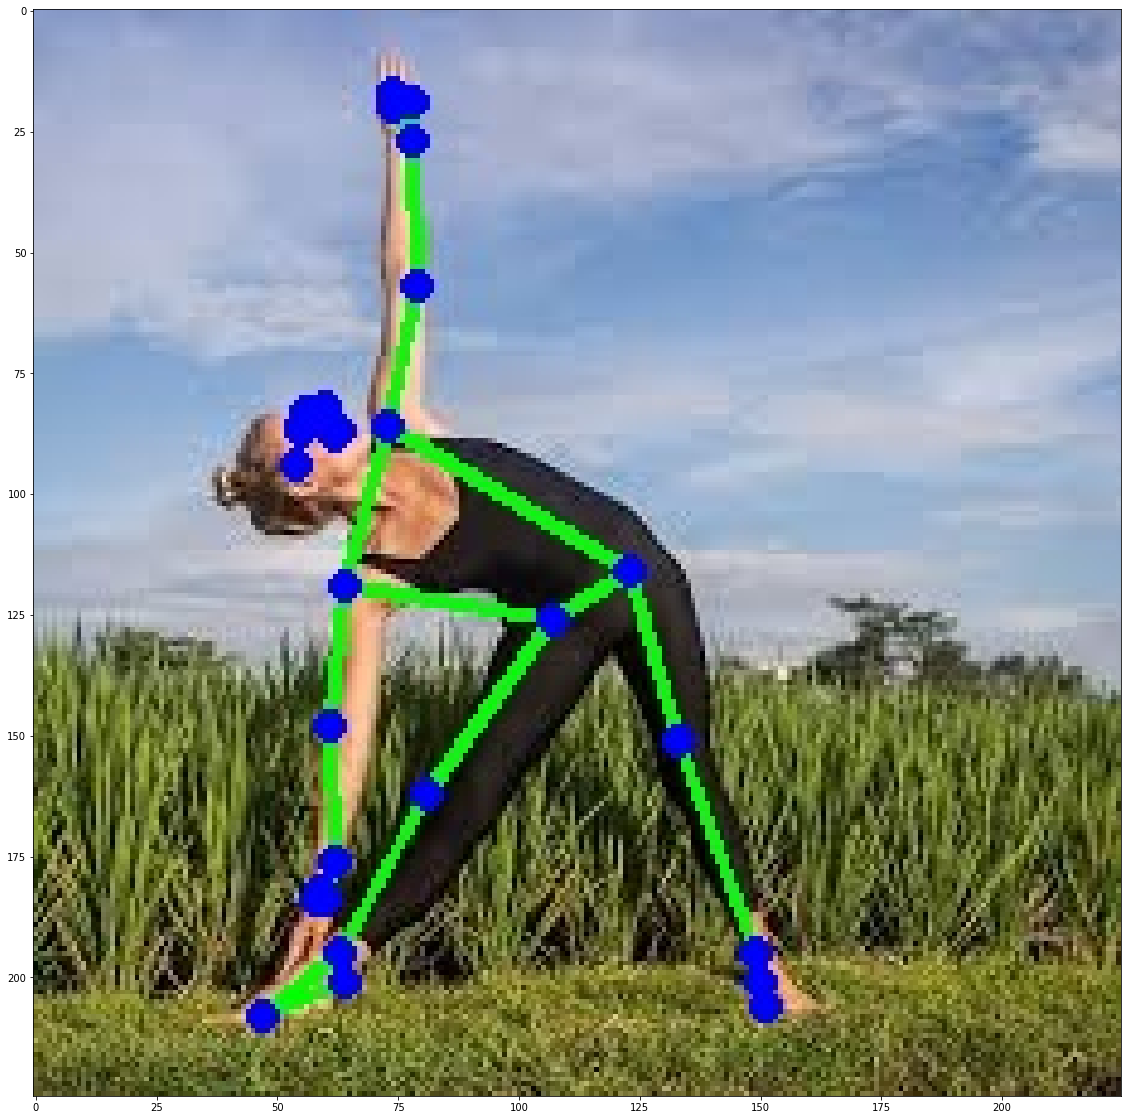

Outlier
  sample path =     fitness_poses_images_out/Trikonasana/Trikonasana14.jpeg
  sample class =    Trikonasana
  detected class =  ['UtthitaParsvakonasana']
  all classes =     {'UtthitaParsvakonasana': 6, 'Trikonasana': 4}


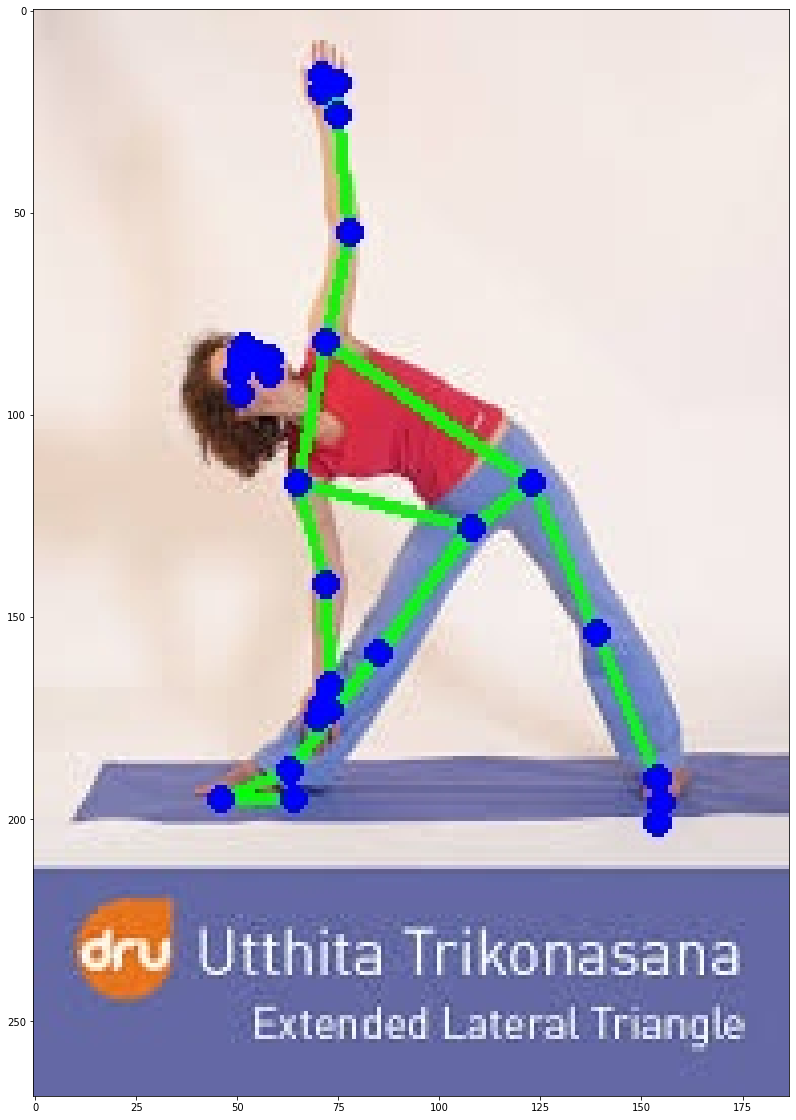

Outlier
  sample path =     fitness_poses_images_out/Trikonasana/Trikonasana15.jpeg
  sample class =    Trikonasana
  detected class =  ['UtthitaParsvakonasana']
  all classes =     {'UtthitaParsvakonasana': 7, 'Trikonasana': 3}


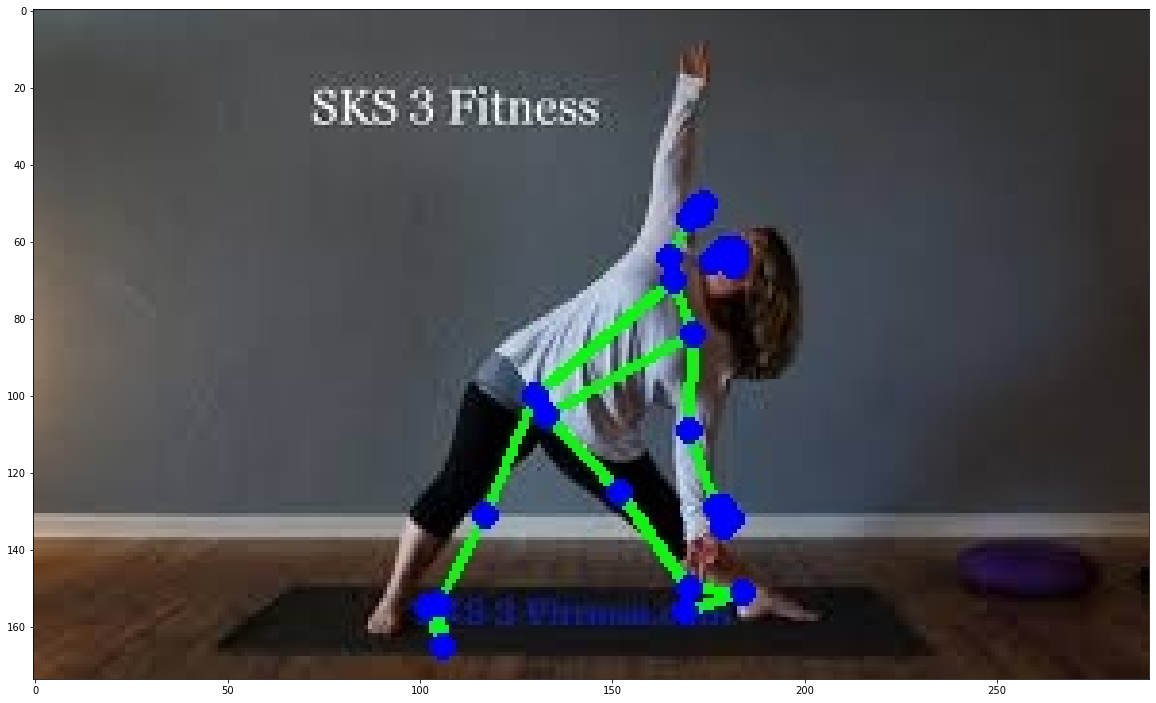

Outlier
  sample path =     fitness_poses_images_out/Trikonasana/Trikonasana9.jpeg
  sample class =    Trikonasana
  detected class =  ['UtthitaParsvakonasana']
  all classes =     {'UtthitaParsvakonasana': 6, 'Trikonasana': 4}


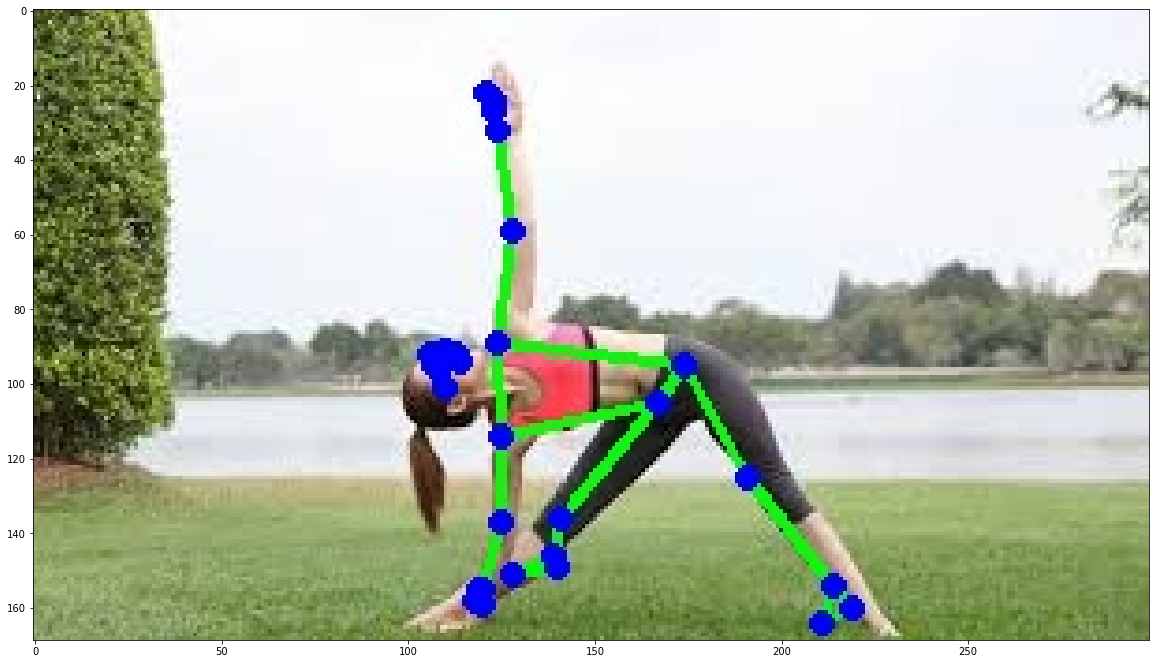

Outlier
  sample path =     fitness_poses_images_out/VirabhadrasanaIII/virabhadrasanaIII_12.jpeg
  sample class =    VirabhadrasanaIII
  detected class =  ['AdhoMukhaSvanasana']
  all classes =     {'VirabhadrasanaIII': 4, 'AdhoMukhaSvanasana': 6}


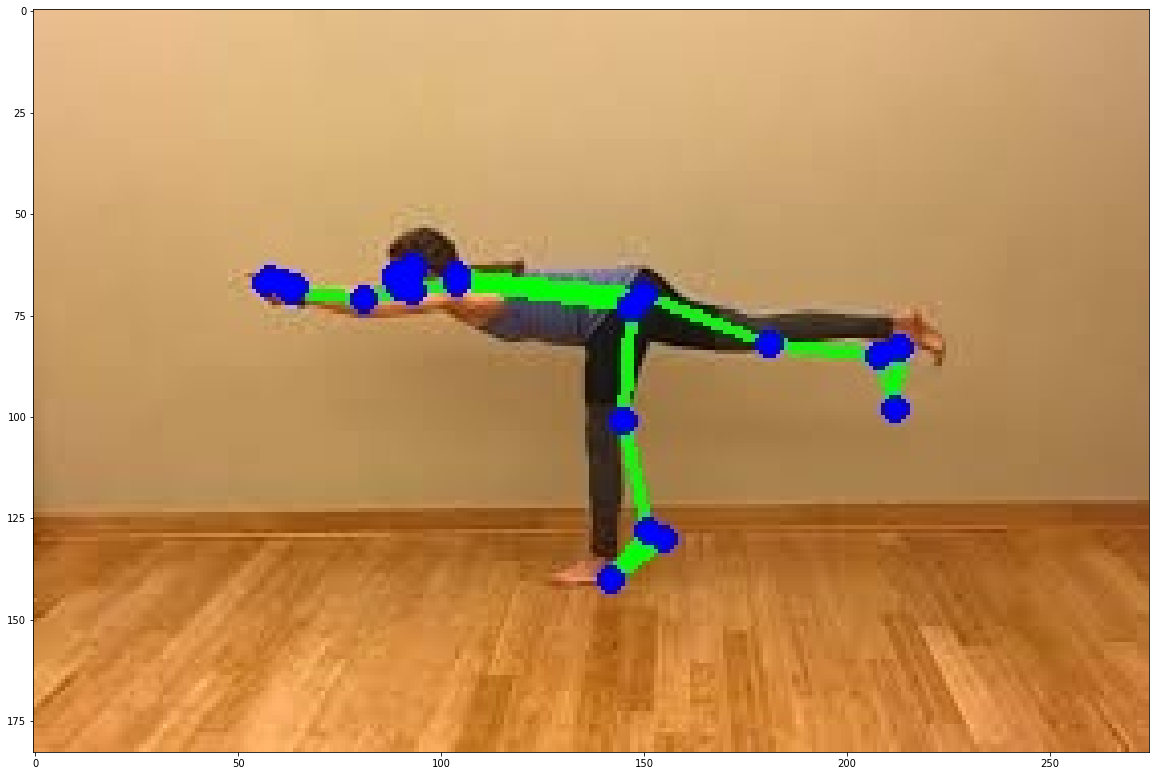

Outlier
  sample path =     fitness_poses_images_out/VirabhadrasanaIII/virabhadrasanaIII_14.jpeg
  sample class =    VirabhadrasanaIII
  detected class =  ['AdhoMukhaSvanasana']
  all classes =     {'VirabhadrasanaIII': 4, 'VirabhadrasanaI': 1, 'AdhoMukhaSvanasana': 5}


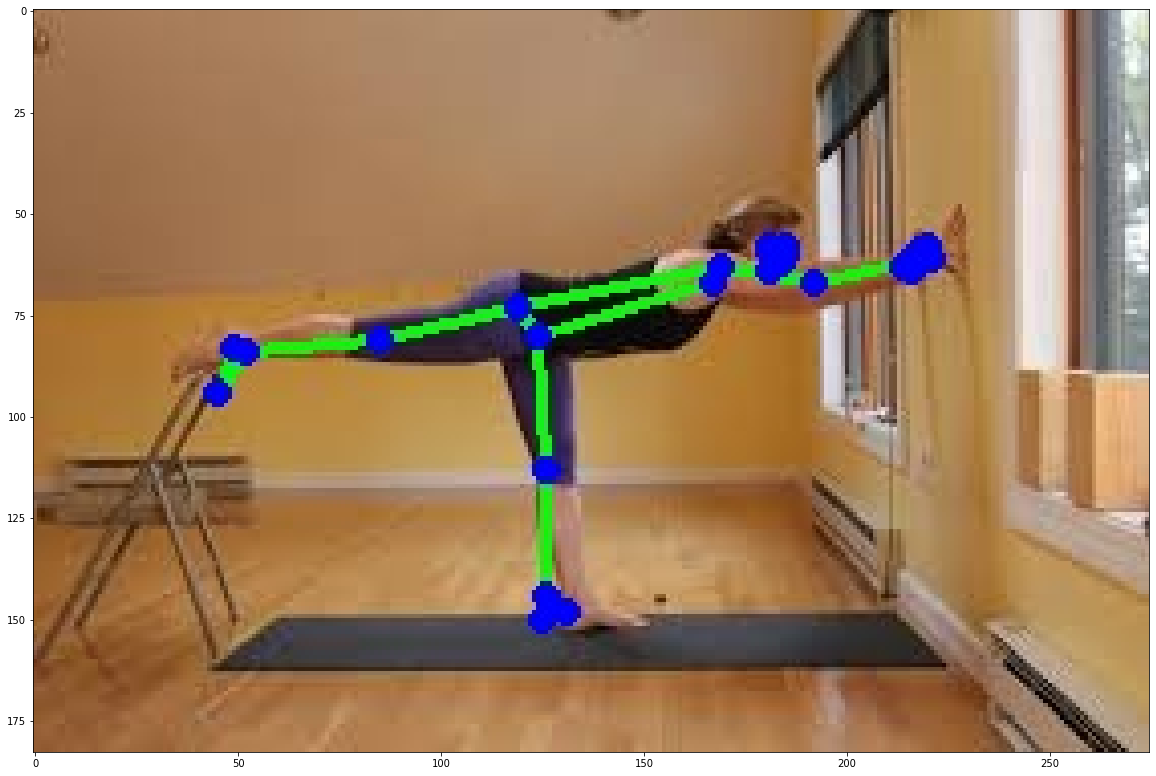

Outlier
  sample path =     fitness_poses_images_out/VirabhadrasanaIII/virabhadrasanaIII_4.jpeg
  sample class =    VirabhadrasanaIII
  detected class =  ['AdhoMukhaSvanasana']
  all classes =     {'VirabhadrasanaIII': 4, 'AdhoMukhaSvanasana': 6}


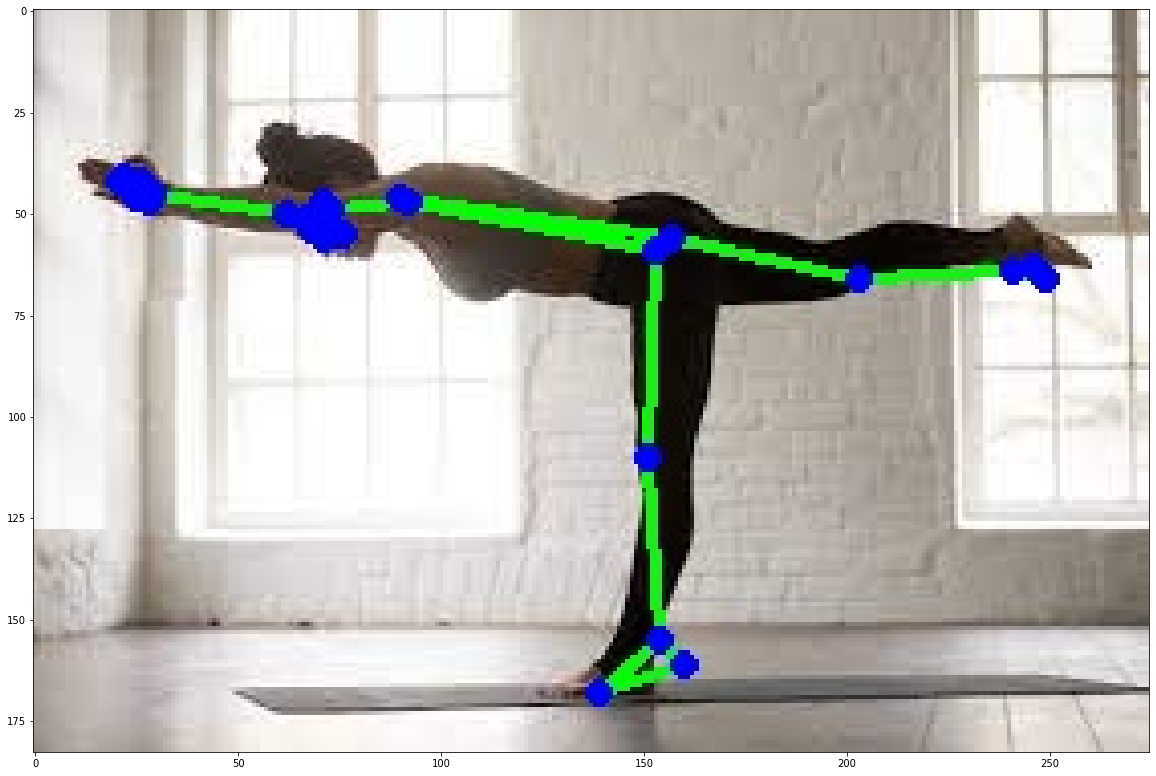

Outlier
  sample path =     fitness_poses_images_out/VirabhadrasanaIII/virabhadrasanaIII_6.jpeg
  sample class =    VirabhadrasanaIII
  detected class =  ['AdhoMukhaSvanasana']
  all classes =     {'VirabhadrasanaIII': 4, 'VirabhadrasanaI': 1, 'AdhoMukhaSvanasana': 5}


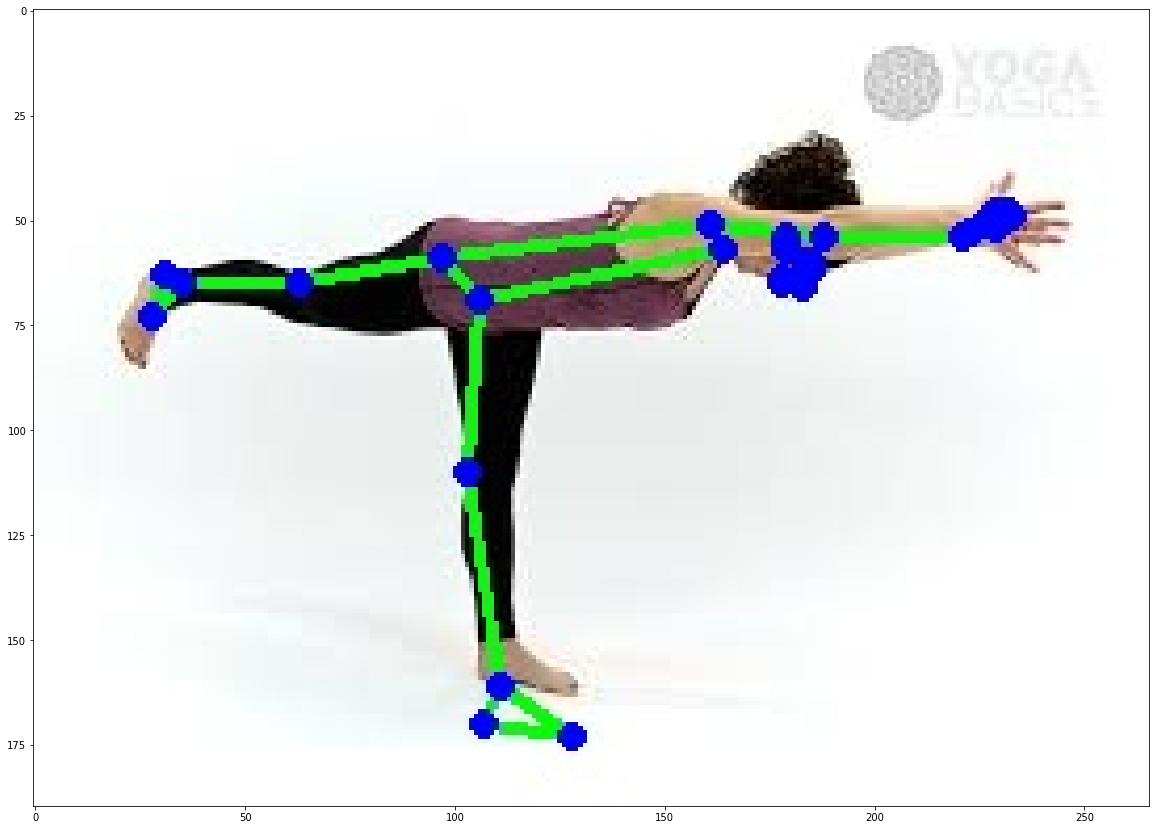

Outlier
  sample path =     fitness_poses_images_out/Uttanasana/uttanasana2.jpeg
  sample class =    Uttanasana
  detected class =  ['Tadasana']
  all classes =     {'Tadasana': 8, 'UrdhvaMukhaShvanasana': 1, 'Uttanasana': 1}


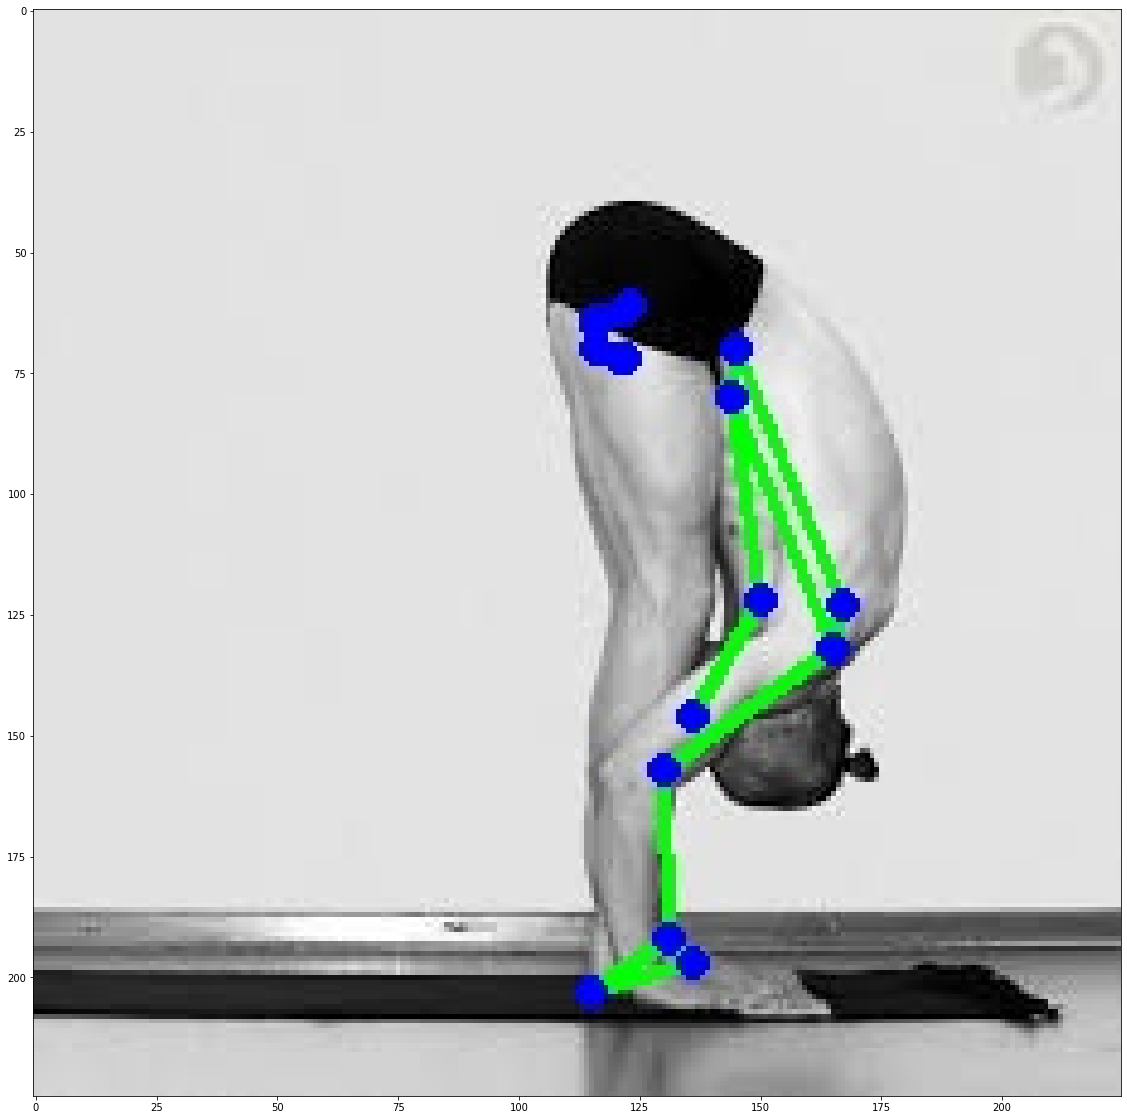

In [ ]:
# Analyze outliers.
bootstrap_helper.analyze_outliers(outliers)

In [ ]:
# Remove all outliers (if you don't want to manually pick).
bootstrap_helper.remove_outliers(outliers)

In [ ]:
# Align CSVs with images after removing outliers.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  AdhoMukhaSvanasana: 21
  Tadasana: 9
  Trikonasana: 17
  UrdhvaMukhaShvanasana: 10
  Uttanasana: 9
  UtthitaParsvakonasana: 22
  VirabhadrasanaI: 27
  VirabhadrasanaII: 17
  VirabhadrasanaIII: 14
  Vrikshasana: 16


## Dump for the App

Dump filtered poses to CSV and download it.

Please check this [guide](https://developers.google.com/ml-kit/vision/pose-detection/classifying-poses#4_integrate_with_the_ml_kit_quickstart_app) on how to use this CSV in the ML Kit sample app.

In [ ]:
import csv
import os
import numpy as np


def dump_for_the_app():
  pose_samples_folder = 'fitness_poses_csvs_out'
  pose_samples_csv_path = 'fitness_poses_csvs_out.csv'
  file_extension = 'csv'
  file_separator = ','

  # Each file in the folder represents one pose class.
  file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

  with open(pose_samples_csv_path, 'w') as csv_out:
    csv_out_writer = csv.writer(csv_out, delimiter=file_separator, quoting=csv.QUOTE_MINIMAL)
    for file_name in file_names:
      # Use file name as pose class name.
      class_name = file_name[:-(len(file_extension) + 1)]

      # One file line: `sample_00001,x1,y1,x2,y2,....`.
      with open(os.path.join(pose_samples_folder, file_name)) as csv_in:
        csv_in_reader = csv.reader(csv_in, delimiter=file_separator)
        for row in csv_in_reader:
          row.insert(1, class_name)
          csv_out_writer.writerow(row)

  files.download(pose_samples_csv_path)


dump_for_the_app()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
pose_samples_folder = 'fitness_poses_csvs_out'
pose_samples_csv_path = 'fitness_poses_csvs_out.csv'
pose_df = pd.read_csv(pose_samples_csv_path)
pose_df.head() 

virabhadrasanaII_1.jpeg  VirabhadrasanaII   84.32151   85.48812  \
0  virabhadrasanaII_10.jpeg  VirabhadrasanaII  132.33202  54.568340   
1  virabhadrasanaII_11.jpeg  VirabhadrasanaII  142.91210  36.036940   
2  virabhadrasanaII_12.jpeg  VirabhadrasanaII  160.99557  32.861572   
3  virabhadrasanaII_13.jpeg  VirabhadrasanaII  160.99557  32.861572   
4  virabhadrasanaII_14.jpeg  VirabhadrasanaII  128.31946  47.309383   

   -83.598045   87.54521   81.28904  -87.18057   88.42542   81.24505  ...  \
0  -87.074554  131.02795  49.834545 -83.725555  131.43578  49.670208  ...   
1  -42.921696  145.39023  32.923020 -45.683790  146.00200  32.922410  ...   
2  -57.151615  159.20465  30.384120 -51.770940  159.30951  30.273636  ...   
3  -57.151615  159.20465  30.384120 -51.770940  159.30951  30.273636  ...   
4  -72.972790  131.11404  44.585330 -74.637990  131.68353  44.765182  ...   

   14.930683   55.455032   208.6374  12.041987  178.22408  213.82527  \
0 -17.425655   33.822113  193.05460 -15.487002  192.20337  200.75491   
1   1.874755  113.733220  156.40419  -0.328004  215.70123  160.00806   
2   5.467030   98.378640  131.89264  -0.394993  208.45619  133.12851   
3   5.467030   98.378640  131.89264  -0.394993  208.45619  133.12851   
4  13.362291   97.277756  148.12546   8.332624  205.69774  156.89380   

   -26.374252  31.180986  211.71895  -14.116774  
0  -44.754387  17.250326  197.28656  -51.678300  
1  -29.524845  94.560610  159.86597  -23.307663  
2  -18.079650  92.887215  134.13516  -34.683876  
3  -18.079650  92.887215  134.13516  -34.683876  
4  -19.839563  77.135280  151.50745  -15.971713  

[5 rows x 101 columns]

In [ ]:
pose_df.shape

(37, 101)

In [ ]:
#import mediapipe as mp
#from mediapipe.python.solutions import pose as mp_pose
#mp_pose = mp.solutions.pose
for lnmark in list(mp_pose.PoseLandmark)[:10]:
    print(lnmark, type(lnmark), lnmark.name,lnmark.value )


PoseLandmark.NOSE <enum 'PoseLandmark'> NOSE 0
PoseLandmark.LEFT_EYE_INNER <enum 'PoseLandmark'> LEFT_EYE_INNER 1
PoseLandmark.LEFT_EYE <enum 'PoseLandmark'> LEFT_EYE 2
PoseLandmark.LEFT_EYE_OUTER <enum 'PoseLandmark'> LEFT_EYE_OUTER 3
PoseLandmark.RIGHT_EYE_INNER <enum 'PoseLandmark'> RIGHT_EYE_INNER 4
PoseLandmark.RIGHT_EYE <enum 'PoseLandmark'> RIGHT_EYE 5
PoseLandmark.RIGHT_EYE_OUTER <enum 'PoseLandmark'> RIGHT_EYE_OUTER 6
PoseLandmark.LEFT_EAR <enum 'PoseLandmark'> LEFT_EAR 7
PoseLandmark.RIGHT_EAR <enum 'PoseLandmark'> RIGHT_EAR 8
PoseLandmark.MOUTH_LEFT <enum 'PoseLandmark'> MOUTH_LEFT 9


In [ ]:
cols1 = [lnmark.name + t  for lnmark in mp_pose.PoseLandmark for t in ["_x","_y","_z"]]
#cols1 = [x for xs in cols1 for x in xs]
cols1[:10]

['NOSE_x',
 'NOSE_y',
 'NOSE_z',
 'LEFT_EYE_INNER_x',
 'LEFT_EYE_INNER_y',
 'LEFT_EYE_INNER_z',
 'LEFT_EYE_x',
 'LEFT_EYE_y',
 'LEFT_EYE_z',
 'LEFT_EYE_OUTER_x']

In [ ]:
cols = ["file_name","Asana"] + cols1
first_row = pose_df.columns
pose_df.columns = cols
pose_df.loc[pose_df.index.values[-1] + 1]  = first_row
pose_df.tail() 

file_name                Asana     NOSE_x      NOSE_y      NOSE_z  \
33  uttanasana6.jpeg           Uttanasana  137.51872   109.02952   -4.196135   
34  uttanasana7.jpeg           Uttanasana   156.1901  102.300026  -28.416357   
35  uttanasana8.jpeg           Uttanasana   99.86045   102.12613   -0.457425   
36  uttanasana9.jpeg           Uttanasana  115.30966   126.32625   -2.482298   
37        adha1.jpeg  ArdhaMukhaSvanasana  107.16465    129.2856  -21.715517   

   LEFT_EYE_INNER_x LEFT_EYE_INNER_y LEFT_EYE_INNER_z  LEFT_EYE_x LEFT_EYE_y  \
33        135.19485        114.28231        -16.16648   134.38667  114.23513   
34        158.21881       105.252174       -24.000282   158.49103  105.12528   
35        104.36007        108.06286         3.031981   105.24615  108.01641   
36       117.490555        132.14433         1.293855  117.946785  132.58904   
37       100.958786        130.11055       -35.203865     100.348  129.63145   

    ... LEFT_HEEL_z RIGHT_HEEL_x RIGHT_HEEL_y RIGHT_HEEL_z LEFT_FOOT_INDEX_x  \
33  ...   -16.29683    161.21385     155.7638    73.373604         143.81897   
34  ...   -1.797322    152.63478    74.471855     2.469792         155.43307   
35  ...   124.80524    53.447968    170.97789    -4.604805          86.57708   
36  ...  102.785484     92.66794    144.19852      38.8052        104.612724   
37  ...  -20.309607    245.06296    144.92728     116.5038          226.2865   

   LEFT_FOOT_INDEX_y LEFT_FOOT_INDEX_z RIGHT_FOOT_INDEX_x RIGHT_FOOT_INDEX_y  \
33         172.64012         -52.10346          133.08614          164.78772   
34         138.83014         -6.819058          154.96013          79.005104   
35         174.22713           99.5958           87.19775          174.12865   
36          164.0463         90.876236           99.27985           165.3927   
37         169.23265        -56.388847          222.62762           161.4506   

   RIGHT_FOOT_INDEX_z  
33           42.91365  
34           2.829174  
35         -39.014828  
36          20.899607  
37           95.96431  

[5 rows x 101 columns]

In [ ]:
pose_samples_folder

'fitness_poses_csvs_out'

In [ ]:
os.listdir(pose_samples_folder)

['ArdhaMukhaShvanasana.csv',
 'Tadasana.csv',
 'Uttanasana.csv',
 'UrdhvaMukhaShvanasana.csv']

In [ ]:
Uttanasana_csv = pd.read_csv(os.path.join(pose_samples_folder,"Uttanasana.csv"))
Uttanasana_csv.head()

uttanasana1.jpeg  146.13545  134.21632  -18.585747  141.80038   138.91957  \
0  uttanasana10.jpeg  196.20715   86.68072   -0.408755  200.97237   83.783745   
1   uttanasana3.jpeg  168.66237  111.68510    4.130997  173.02190  110.847310   
2   uttanasana4.jpeg   94.36210  157.59810  -15.946104   89.77868  162.850900   
3   uttanasana5.jpeg   92.78037  212.06888  -25.206993   94.36877  215.423680   
4   uttanasana6.jpeg  137.51872  109.02952   -4.196135  135.19485  114.282310   

   -26.432037  140.40675   138.65813  -26.397585  ...   8.922799  181.36359  \
0    1.106246  201.05879   83.092680    1.144014  ...  84.299355  100.12076   
1    6.496616  173.47630  110.318405    6.522516  ...  60.231693  110.59546   
2  -27.836580   88.74432  162.467580  -27.883160  ... -38.097900  134.69612   
3  -23.839314   94.86852  215.536500  -23.807339  ...  25.755186   61.32932   
4  -16.166480  134.38667  114.235130  -16.206078  ... -16.296830  161.21385   

   153.09714  62.248947  180.14842  177.39609  -19.915503   169.77151  \
0  186.35179  23.819555  133.51265  175.94154   59.520760  131.596510   
1  156.02449  18.905785  136.33250  156.85803   40.693410  133.984540   
2  210.19360  62.285190  109.47709  231.74403  -86.450350  100.429960   
3  263.19977 -46.794445   84.46900  268.59360    3.367143   85.260284   
4  155.76380  73.373604  143.81897  172.64012  -52.103460  133.086140   

   172.57365   35.28103  
0  184.68428  -8.412427  
1  160.18390  -8.315209  
2  223.56593  23.908157  
3  273.91920 -78.661540  
4  164.78772  42.913650  

[5 rows x 100 columns]

# Step 2: Classification

**Important!!** Check that you are using the same classification parameters as while building classifier.

In [ ]:
%%time
# Upload your video.
uploaded = files.upload()
os.listdir('.')

Saving basic_vid.mov to basic_vid.mov
CPU times: user 5.58 s, sys: 569 ms, total: 6.15 s
Wall time: 3min 58s


In [ ]:
os.listdir(".")

['.config',
 'fitness_poses_csvs_out.csv',
 'Trim21.mov',
 'fitness_poses_images_in',
 'fitness_poses_images_in.zip',
 'fitness_poses_csvs_out',
 'fitness_poses_images_out',
 'sample_data']

In [ ]:
# Specify your video name and target pose class to count the repetitions.
#video_path = 'pushups-sample.mov'
#video_path = 'TrimSeq.mov'
#video_path = 'Trim21.mov'
video_path = "basic_vid.mov"
class_name = "UrdhvaMukhaShvanasana"
#class_name='pushups_down'
out_video_path = "test-out.mov" #'pushups-sample-out.mov'

In [ ]:
# Open the video.
import cv2

video_cap = cv2.VideoCapture(video_path)

# Get some video parameters to generate output video with classificaiton.
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [ ]:
%%time
# Initilize tracker, classifier and counter.
# Do that before every video as all of them have state.
from mediapipe.python.solutions import pose as mp_pose


# Folder with pose class CSVs. That should be the same folder you using while
# building classifier to output CSVs.
pose_samples_folder = 'fitness_poses_csvs_out'

# Initialize tracker.
pose_tracker = mp_pose.Pose(upper_body_only=False)

# Initialize embedder.
pose_embedder = FullBodyPoseEmbedder()

# Initialize classifier.
# Ceck that you are using the same parameters as during bootstrapping.
pose_classifier = PoseClassifier(
    pose_samples_folder=pose_samples_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

# # Uncomment to validate target poses used by classifier and find outliers.
# outliers = pose_classifier.find_pose_sample_outliers()
# print('Number of pose sample outliers (consider removing them): ', len(outliers))

# Initialize EMA smoothing.
pose_classification_filter = EMADictSmoothing(
    window_size=10,
    alpha=0.2)

# Initialize counter.
repetition_counter = RepetitionCounter(
    class_name=class_name,
    enter_threshold=6,
    exit_threshold=4)

# Initialize renderer.
pose_classification_visualizer = PoseClassificationVisualizer2(
    class_name=class_name,
    plot_x_max=video_n_frames,
    # Graphic looks nicer if it's the same as `top_n_by_mean_distance`.
    plot_y_max=10)

CPU times: user 137 ms, sys: 18.7 ms, total: 155 ms
Wall time: 122 ms


In [ ]:
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [ ]:
video_n_frames

558.0

  0%|          | 0/558.0 [00:00<?, ?it/s]

#######################################################
None
#######################################################


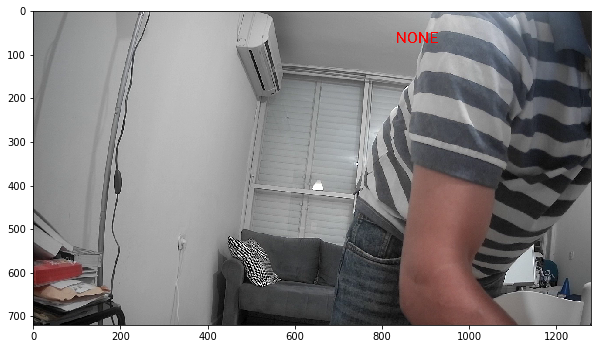

  0%|          | 2/558.0 [00:01<05:27,  1.70it/s]

#######################################################
None
#######################################################


  1%|          | 3/558.0 [00:01<04:12,  2.20it/s]

#######################################################
None
#######################################################


  1%|          | 6/558.0 [00:02<01:55,  4.76it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  1%|▏         | 8/558.0 [00:02<01:24,  6.53it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  2%|▏         | 12/558.0 [00:02<00:59,  9.14it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  3%|▎         | 14/558.0 [00:02<00:53, 10.12it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  3%|▎         | 18/558.0 [00:02<00:47, 11.32it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  4%|▎         | 20/558.0 [00:03<00:45, 11.79it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  4%|▍         | 24/558.0 [00:03<00:44, 11.97it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  5%|▌         | 28/558.0 [00:03<00:43, 12.23it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  5%|▌         | 30/558.0 [00:03<00:43, 12.15it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  6%|▌         | 34/558.0 [00:04<00:41, 12.49it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  7%|▋         | 38/558.0 [00:04<00:41, 12.46it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  7%|▋         | 40/558.0 [00:04<00:41, 12.45it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  8%|▊         | 44/558.0 [00:05<00:41, 12.29it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  8%|▊         | 46/558.0 [00:05<00:42, 12.09it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


  9%|▉         | 50/558.0 [00:05<00:41, 12.16it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


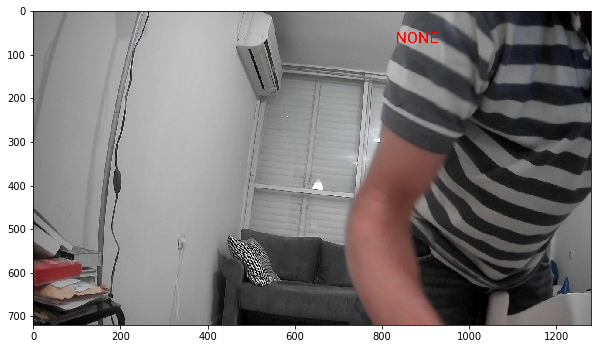

 10%|▉         | 54/558.0 [00:06<01:08,  7.39it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 10%|█         | 56/558.0 [00:06<01:01,  8.18it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 11%|█         | 60/558.0 [00:06<00:50,  9.86it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 11%|█         | 62/558.0 [00:07<00:47, 10.45it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 12%|█▏        | 66/558.0 [00:07<00:44, 11.12it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 12%|█▏        | 68/558.0 [00:07<00:43, 11.25it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 13%|█▎        | 72/558.0 [00:07<00:41, 11.83it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 13%|█▎        | 74/558.0 [00:08<00:39, 12.11it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################


 14%|█▎        | 76/558.0 [00:08<00:43, 11.02it/s]

#######################################################
{'Tadasana': 2.016522449283008, 'UrdhvaMukhaShvanasana': 0.2240580499203342}
#######################################################
#######################################################
{'Tadasana': 3.629740408709414, 'UrdhvaMukhaShvanasana': 0.40330448985660156}
#######################################################
#######################################################
{'Tadasana': 4.92031477625054, 'UrdhvaMukhaShvanasana': 0.5467016418056155}
#######################################################


 14%|█▍        | 80/558.0 [00:08<00:41, 11.59it/s]

#######################################################
{'Tadasana': 5.95277427028344, 'UrdhvaMukhaShvanasana': 0.6614193633648267}
#######################################################
#######################################################
{'Tadasana': 6.77874186550976, 'UrdhvaMukhaShvanasana': 0.7531935406121956}
#######################################################
#######################################################
{'Tadasana': 7.439515941690816, 'UrdhvaMukhaShvanasana': 0.8266128824100907}
#######################################################


 15%|█▍        | 82/558.0 [00:08<00:39, 11.96it/s]

#######################################################
{'Vrikshasana': 0.2240580499203342, 'Tadasana': 7.968135202635661, 'UrdhvaMukhaShvanasana': 0.6612903059280726}
#######################################################
#######################################################
{'Vrikshasana': 0.40330448985660156, 'Tadasana': 8.391030611391537, 'UrdhvaMukhaShvanasana': 0.5290322447424581}
#######################################################
#######################################################
{'Vrikshasana': 0.5467016418056155, 'Tadasana': 8.729346938396239, 'UrdhvaMukhaShvanasana': 0.4232257957939665}
#######################################################


 15%|█▌        | 86/558.0 [00:09<00:37, 12.46it/s]

#######################################################
{'Vrikshasana': 0.43736131344449247, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.5626386865555074}
#######################################################
#######################################################
{'Vrikshasana': 0.5739471006759281, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.42605289932407175}
#######################################################
#######################################################
{'Vrikshasana': 0.6832157304610768, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.31678426953892314}
#######################################################


 16%|█▌        | 88/558.0 [00:09<00:37, 12.60it/s]

#######################################################
{'Vrikshasana': 0.5465725843688615, 'Uttanasana': 0.2240580499203342, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.22936936571080419}
#######################################################
#######################################################
{'Vrikshasana': 0.6613161174154234, 'Uttanasana': 0.17924643993626738, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.1594374426483091}
#######################################################
#######################################################
{'Vrikshasana': 0.7531109438526731, 'Uttanasana': 0.14339715194901392, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.10349190419831299}
#######################################################


 16%|█▋        | 92/558.0 [00:09<00:37, 12.37it/s]

#######################################################
{'Vrikshasana': 0.8265468050024727, 'Uttanasana': 0.11471772155921114, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.058735473438316116}
#######################################################
#######################################################
{'Vrikshasana': 0.861237444001978, 'Uttanasana': 0.09177417724736892, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.0469883787506529}
#######################################################
#######################################################
{'Vrikshasana': 0.8889899552015824, 'Uttanasana': 0.07341934179789514, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.037590703000522314}
#######################################################


 17%|█▋        | 94/558.0 [00:09<00:37, 12.37it/s]

#######################################################
{'Vrikshasana': 0.911191964161266, 'Uttanasana': 0.058735473438316116, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.030072562400417852}
#######################################################
#######################################################
{'Vrikshasana': 0.953011621249347, 'Uttanasana': 0.0469883787506529, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.9624092969994776, 'Uttanasana': 0.037590703000522314, 'Tadasana': 8.999999999999998}
#######################################################


 18%|█▊        | 98/558.0 [00:10<00:38, 12.02it/s]

#######################################################
{'Vrikshasana': 0.9699274375995821, 'Uttanasana': 0.030072562400417852, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 18%|█▊        | 100/558.0 [00:10<00:41, 11.15it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


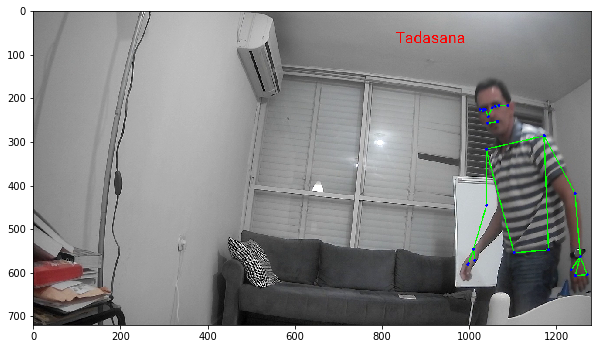

 18%|█▊        | 103/558.0 [00:11<01:09,  6.58it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 19%|█▉        | 107/558.0 [00:11<00:49,  9.07it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 20%|█▉        | 109/558.0 [00:11<00:44, 10.07it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.7759419500796657, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.2240580499203342}
#######################################################
#######################################################
{'Vrikshasana': 0.5966955101433983, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.40330448985660156}
#######################################################


 20%|██        | 113/558.0 [00:11<00:38, 11.43it/s]

#######################################################
{'Vrikshasana': 0.45329835819438435, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.5467016418056155}
#######################################################
#######################################################
{'Vrikshasana': 0.3385806366351733, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.6614193633648267}
#######################################################
#######################################################
{'Vrikshasana': 0.2468064593878043, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.7531935406121956}
#######################################################
#######################################################
{'Vrikshasana': 0.17338711758990918, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.8266128824100907}
#######################################################


 21%|██        | 117/558.0 [00:12<00:35, 12.27it/s]

#######################################################
{'Vrikshasana': 0.11465164415159307, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.8853483558484069}
#######################################################
#######################################################
{'Vrikshasana': 0.06766326540094017, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.9323367345990597}
#######################################################
#######################################################
{'Vrikshasana': 0.030072562400417852, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.9699274375995821}
#######################################################


 21%|██▏       | 119/558.0 [00:12<00:35, 12.32it/s]

#######################################################
{'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 1.0}
#######################################################
#######################################################
{'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 1.0}
#######################################################
#######################################################
{'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 1.0}
#######################################################


 22%|██▏       | 123/558.0 [00:12<00:34, 12.44it/s]

#######################################################
{'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 1.0}
#######################################################
#######################################################
{'Tadasana': 8.775941950079664, 'UrdhvaMukhaShvanasana': 1.224058049920334}
#######################################################
#######################################################
{'Tadasana': 8.596695510143398, 'UrdhvaMukhaShvanasana': 1.4033044898566016}
#######################################################


 22%|██▏       | 125/558.0 [00:12<00:35, 12.09it/s]

#######################################################
{'Tadasana': 8.453298358194383, 'UrdhvaMukhaShvanasana': 1.5467016418056156}
#######################################################
#######################################################
{'Uttanasana': 0.2240580499203342, 'Tadasana': 8.114522586714838, 'UrdhvaMukhaShvanasana': 1.6614193633648267}
#######################################################
#######################################################
{'Uttanasana': 0.40330448985660156, 'Tadasana': 6.72321171992953, 'AdhoMukhaSvanasana': 0.6721741497610026, 'UrdhvaMukhaShvanasana': 2.2013096404528634}
#######################################################


 23%|██▎       | 129/558.0 [00:13<00:33, 12.62it/s]

#######################################################
{'Uttanasana': 0.5467016418056155, 'Tadasana': 5.162046926660616, 'AdhoMukhaSvanasana': 1.8820876193308074, 'UrdhvaMukhaShvanasana': 2.409163812202959}
#######################################################
#######################################################
{'Uttanasana': 0.6614193633648267, 'Tadasana': 3.9131150920454854, 'AdhoMukhaSvanasana': 3.0740764449069853, 'UrdhvaMukhaShvanasana': 2.3513890996827014}
#######################################################
#######################################################
{'Uttanasana': 0.5291354906918614, 'Tadasana': 2.9139696243533795, 'AdhoMukhaSvanasana': 4.251725555288263, 'UrdhvaMukhaShvanasana': 2.3051693296664957}
#######################################################


 23%|██▎       | 131/558.0 [00:13<00:33, 12.57it/s]

#######################################################
{'Uttanasana': 0.4233083925534891, 'Tadasana': 2.114653250199695, 'AdhoMukhaSvanasana': 5.417902893513618, 'UrdhvaMukhaShvanasana': 2.0441354637331965}
#######################################################
#######################################################
{'Uttanasana': 0.33864671404279134, 'Tadasana': 1.4752001508767476, 'AdhoMukhaSvanasana': 6.574902814014235, 'UrdhvaMukhaShvanasana': 1.6112503210662232}
#######################################################
#######################################################
{'Uttanasana': 0.2709173712342331, 'Tadasana': 0.987695721338724, 'AdhoMukhaSvanasana': 7.500502750414731, 'UrdhvaMukhaShvanasana': 1.2408841570123101}
#######################################################


 24%|██▍       | 135/558.0 [00:13<00:33, 12.50it/s]

#######################################################
{'Uttanasana': 0.21673389698738646, 'Tadasana': 0.5976921777083049, 'AdhoMukhaSvanasana': 8.24098269953513, 'UrdhvaMukhaShvanasana': 0.9445912257691796}
#######################################################
#######################################################
{'Uttanasana': 0.17338711758990918, 'Tadasana': 0.28568934280396957, 'AdhoMukhaSvanasana': 8.833366658831446, 'UrdhvaMukhaShvanasana': 0.707556880774675}
#######################################################
#######################################################
{'Uttanasana': 0.11465164415159307, 'Tadasana': 0.060145124800835705, 'AdhoMukhaSvanasana': 9.3072738262685, 'UrdhvaMukhaShvanasana': 0.5179294047790716}
#######################################################


 25%|██▍       | 137/558.0 [00:13<00:34, 12.24it/s]

#######################################################
{'Uttanasana': 0.06766326540094017, 'AdhoMukhaSvanasana': 9.61422541045714, 'UrdhvaMukhaShvanasana': 0.31811132414192006}
#######################################################
#######################################################
{'Uttanasana': 0.030072562400417852, 'AdhoMukhaSvanasana': 9.787612528047049, 'UrdhvaMukhaShvanasana': 0.18231490955253327}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.902264172198642, 'UrdhvaMukhaShvanasana': 0.09773582780135803}
#######################################################


 25%|██▌       | 141/558.0 [00:14<00:33, 12.57it/s]

#######################################################
{'AdhoMukhaSvanasana': 9.96992743759958, 'UrdhvaMukhaShvanasana': 0.030072562400417852}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################


 26%|██▌       | 143/558.0 [00:14<00:33, 12.56it/s]

#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################


 26%|██▋       | 147/558.0 [00:14<00:32, 12.80it/s]

#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################


 27%|██▋       | 149/558.0 [00:14<00:32, 12.71it/s]

#######################################################
{'AdhoMukhaSvanasana': 9.999999999999998}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.775941950079664, 'UrdhvaMukhaShvanasana': 0.2240580499203342}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.596695510143396, 'UrdhvaMukhaShvanasana': 0.40330448985660156}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 8.557066158513045, 'UrdhvaMukhaShvanasana': 1.4429338414869521}
#######################################################


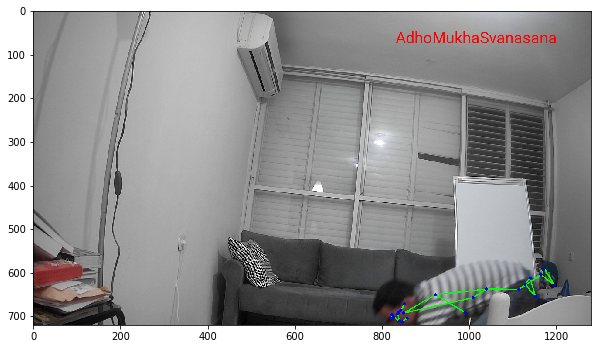

 28%|██▊       | 154/558.0 [00:15<00:48,  8.40it/s]

#######################################################
{'AdhoMukhaSvanasana': 8.397536826969768, 'UrdhvaMukhaShvanasana': 1.6024631730302306}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 8.045855311814812, 'UrdhvaMukhaShvanasana': 1.954144688185187}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.540452049770512, 'UrdhvaMukhaShvanasana': 2.459547950229487}
#######################################################


 28%|██▊       | 156/558.0 [00:15<00:42,  9.50it/s]

#######################################################
{'AdhoMukhaSvanasana': 6.688013340294405, 'UrdhvaMukhaShvanasana': 3.3119866597055942}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.333888222952515, 'UrdhvaMukhaShvanasana': 4.666111777047483}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 4.698704228919672, 'UrdhvaMukhaShvanasana': 5.301295771080326}
#######################################################


 29%|██▊       | 160/558.0 [00:15<00:36, 10.97it/s]

#######################################################
{'AdhoMukhaSvanasana': 4.190557033693398, 'UrdhvaMukhaShvanasana': 5.8094429663066}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 4.928387577034385, 'UrdhvaMukhaShvanasana': 5.0716124229656145}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.070535911866504, 'UrdhvaMukhaShvanasana': 4.929464088133496}
#######################################################


 29%|██▉       | 162/558.0 [00:16<00:34, 11.37it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.504544829333871, 'UrdhvaMukhaShvanasana': 4.495455170666126}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 6.22769391338743, 'UrdhvaMukhaShvanasana': 3.772306086612568}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 6.830271230550613, 'UrdhvaMukhaShvanasana': 3.1697287694493856}
#######################################################


 30%|██▉       | 166/558.0 [00:16<00:32, 12.06it/s]

#######################################################
{'AdhoMukhaSvanasana': 7.336391134201492, 'UrdhvaMukhaShvanasana': 2.6636088657985058}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.789403156962866, 'UrdhvaMukhaShvanasana': 2.210596843037133}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.999928875012633, 'UrdhvaMukhaShvanasana': 2.0000711249873664}
#######################################################


 30%|███       | 168/558.0 [00:16<00:32, 12.11it/s]

#######################################################
{'AdhoMukhaSvanasana': 8.120233349611778, 'UrdhvaMukhaShvanasana': 1.8797666503882215}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.992418879370759, 'UrdhvaMukhaShvanasana': 2.0075811206292404}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.993935103496608, 'UrdhvaMukhaShvanasana': 2.006064896503392}
#######################################################


 31%|███       | 172/558.0 [00:16<00:31, 12.28it/s]

#######################################################
{'AdhoMukhaSvanasana': 8.26732223255829, 'UrdhvaMukhaShvanasana': 1.7326777674417106}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 8.013857786046628, 'UrdhvaMukhaShvanasana': 1.9861422139533682}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.090795979235633, 'UrdhvaMukhaShvanasana': 2.9092040207643657}
#######################################################


 31%|███       | 174/558.0 [00:17<00:31, 12.19it/s]

#######################################################
{'AdhoMukhaSvanasana': 6.57640458370717, 'UrdhvaMukhaShvanasana': 3.4235954162928297}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.940833417364065, 'UrdhvaMukhaShvanasana': 4.059166582635934}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.208318434369245, 'UrdhvaMukhaShvanasana': 4.791681565630753}
#######################################################


 32%|███▏      | 178/558.0 [00:17<00:31, 12.25it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.318538647654727, 'UrdhvaMukhaShvanasana': 4.681461352345269}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.406714818283113, 'UrdhvaMukhaShvanasana': 4.593285181716887}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.277255754785822, 'UrdhvaMukhaShvanasana': 4.722744245214176}
#######################################################


 32%|███▏      | 180/558.0 [00:17<00:30, 12.32it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.597746553908322, 'UrdhvaMukhaShvanasana': 4.402253446091676}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.830081143285989, 'UrdhvaMukhaShvanasana': 4.169918856714009}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.615948814788123, 'UrdhvaMukhaShvanasana': 4.3840511852118755}
#######################################################


 33%|███▎      | 184/558.0 [00:17<00:30, 12.19it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.740875151671167, 'UrdhvaMukhaShvanasana': 4.259124848328832}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.816758171257268, 'UrdhvaMukhaShvanasana': 4.18324182874273}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.901522636846484, 'UrdhvaMukhaShvanasana': 4.098477363153516}
#######################################################


 33%|███▎      | 186/558.0 [00:18<00:31, 11.96it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.99339225923819, 'UrdhvaMukhaShvanasana': 4.00660774076181}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.994713807390551, 'UrdhvaMukhaShvanasana': 4.005286192609448}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.9957710459124405, 'UrdhvaMukhaShvanasana': 4.004228954087559}
#######################################################


 34%|███▍      | 190/558.0 [00:18<00:31, 11.59it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.796616836729952, 'UrdhvaMukhaShvanasana': 4.203383163270046}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.813235419463626, 'UrdhvaMukhaShvanasana': 4.186764580536371}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.826530285650568, 'UrdhvaMukhaShvanasana': 4.173469714349431}
#######################################################


 34%|███▍      | 192/558.0 [00:18<00:31, 11.50it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.885282278440789, 'UrdhvaMukhaShvanasana': 4.11471772155921}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.908225822752631, 'UrdhvaMukhaShvanasana': 4.091774177247368}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 6.150638708122439, 'UrdhvaMukhaShvanasana': 3.8493612918775613}
#######################################################


 35%|███▌      | 196/558.0 [00:18<00:30, 11.71it/s]

#######################################################
{'AdhoMukhaSvanasana': 6.1205109664979505, 'UrdhvaMukhaShvanasana': 3.879489033502048}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 6.096408773198361, 'UrdhvaMukhaShvanasana': 3.9035912268016384}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.853068968638353, 'UrdhvaMukhaShvanasana': 4.146931031361644}
#######################################################


 35%|███▌      | 198/558.0 [00:19<00:30, 11.92it/s]

#######################################################
{'AdhoMukhaSvanasana': 5.882455174910683, 'UrdhvaMukhaShvanasana': 4.117544825089316}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.2240580499203342, 'AdhoMukhaSvanasana': 5.930022189848881, 'UrdhvaMukhaShvanasana': 3.8459197602307844}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.40330448985660156, 'AdhoMukhaSvanasana': 5.944017751879105, 'UrdhvaMukhaShvanasana': 3.652677758264293}
#######################################################


 36%|███▌      | 200/558.0 [00:19<00:29, 12.25it/s]

#######################################################
{'VirabhadrasanaIII': 0.5467016418056155, 'AdhoMukhaSvanasana': 5.955214201503284, 'UrdhvaMukhaShvanasana': 3.4980841566910996}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.43736131344449247, 'AdhoMukhaSvanasana': 6.18822941112296, 'UrdhvaMukhaShvanasana': 3.374409275432546}
#######################################################


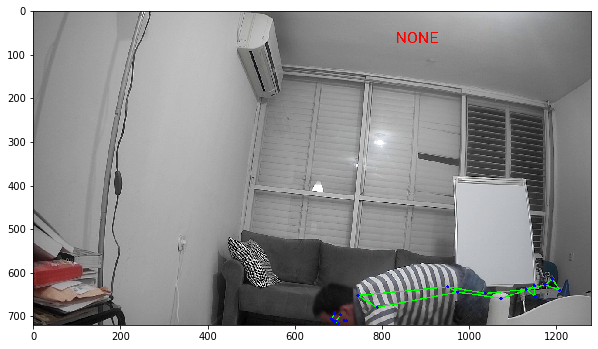

 37%|███▋      | 204/558.0 [00:20<00:46,  7.61it/s]

#######################################################
{'VirabhadrasanaIII': 0.34988905075559396, 'AdhoMukhaSvanasana': 6.150583528898368, 'UrdhvaMukhaShvanasana': 3.4995274203460363}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.2799112406044752, 'AdhoMukhaSvanasana': 6.320466823118695, 'UrdhvaMukhaShvanasana': 3.399621936276829}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.22392899248358017, 'AdhoMukhaSvanasana': 6.928547608255958, 'UrdhvaMukhaShvanasana': 2.8475233992604605}
#######################################################
#######################################################

 37%|███▋      | 206/558.0 [00:20<00:40,  8.60it/s]


{'VirabhadrasanaIII': 0.17914319398686415, 'AdhoMukhaSvanasana': 7.41501223636577, 'UrdhvaMukhaShvanasana': 2.405844569647366}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.14331455518949132, 'AdhoMukhaSvanasana': 7.828241988773951, 'UrdhvaMukhaShvanasana': 2.0284434560365554}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.11465164415159307, 'AdhoMukhaSvanasana': 8.134767740780164, 'UrdhvaMukhaShvanasana': 1.7505806150682415}
#######################################################


 38%|███▊      | 210/558.0 [00:20<00:34,  9.97it/s]

#######################################################
{'VirabhadrasanaIII': 0.06766326540094017, 'AdhoMukhaSvanasana': 8.379988342385134, 'UrdhvaMukhaShvanasana': 1.5523483922139247}
#######################################################
#######################################################
{'VirabhadrasanaIII': 0.030072562400417852, 'AdhoMukhaSvanasana': 8.576164823669112, 'UrdhvaMukhaShvanasana': 1.393762613930471}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 8.73310600869629, 'UrdhvaMukhaShvanasana': 1.2668939913037085}
#######################################################


 38%|███▊      | 212/558.0 [00:20<00:32, 10.49it/s]

#######################################################
{'AdhoMukhaSvanasana': 8.834600906797702, 'UrdhvaMukhaShvanasana': 1.1653990932022982}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.163912925119497, 'UrdhvaMukhaShvanasana': 0.8360870748805014}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.179246439936266, 'UrdhvaMukhaShvanasana': 0.8207535600637325}
#######################################################


 39%|███▊      | 216/558.0 [00:21<00:30, 11.32it/s]

#######################################################
{'AdhoMukhaSvanasana': 9.367455201869348, 'UrdhvaMukhaShvanasana': 0.6325447981306518}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.518022211415811, 'UrdhvaMukhaShvanasana': 0.48197778858418716}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.41441776913265, 'UrdhvaMukhaShvanasana': 0.5855822308673496}
#######################################################


 39%|███▉      | 218/558.0 [00:21<00:29, 11.65it/s]

#######################################################
{'AdhoMukhaSvanasana': 9.555592265226453, 'UrdhvaMukhaShvanasana': 0.4444077347735455}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.444473812181162, 'UrdhvaMukhaShvanasana': 0.5555261878188363}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 9.131520999824595, 'UrdhvaMukhaShvanasana': 0.8684790001754031}
#######################################################


 40%|███▉      | 222/558.0 [00:21<00:28, 11.95it/s]

#######################################################
{'AdhoMukhaSvanasana': 8.433042650098674, 'UrdhvaMukhaShvanasana': 1.5669573499013252}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.874259970317936, 'UrdhvaMukhaShvanasana': 2.125740029682063}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 7.179117726652678, 'UrdhvaMukhaShvanasana': 2.820882273347321}
#######################################################


 40%|████      | 224/558.0 [00:21<00:27, 12.10it/s]

#######################################################
{'AdhoMukhaSvanasana': 6.198945881800135, 'UrdhvaMukhaShvanasana': 3.8010541181998625}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.614808405918104, 'UrdhvaMukhaShvanasana': 4.3851915940818955}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 5.147498425212477, 'UrdhvaMukhaShvanasana': 4.852501574787522}
#######################################################


 41%|████      | 228/558.0 [00:22<00:27, 12.07it/s]

#######################################################
{'AdhoMukhaSvanasana': 4.349592390727642, 'UrdhvaMukhaShvanasana': 5.6504076092723565}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.6872095132194387, 'UrdhvaMukhaShvanasana': 6.3127904867805595}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.405419311053546, 'UrdhvaMukhaShvanasana': 6.594580688946453}
#######################################################


 41%|████      | 230/558.0 [00:22<00:26, 12.17it/s]

#######################################################
{'AdhoMukhaSvanasana': 4.100277398922502, 'UrdhvaMukhaShvanasana': 5.899722601077498}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 4.032105819297333, 'UrdhvaMukhaShvanasana': 5.967894180702666}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.977568555597197, 'UrdhvaMukhaShvanasana': 6.022431444402801}
#######################################################


 42%|████▏     | 234/558.0 [00:22<00:25, 12.61it/s]

#######################################################
{'AdhoMukhaSvanasana': 3.9579967945574244, 'UrdhvaMukhaShvanasana': 6.042003205442575}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.5423393857256045, 'UrdhvaMukhaShvanasana': 6.457660614274395}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.633871508580483, 'UrdhvaMukhaShvanasana': 6.3661284914195155}
#######################################################


 42%|████▏     | 236/558.0 [00:22<00:25, 12.52it/s]

#######################################################
{'AdhoMukhaSvanasana': 3.4830391569440526, 'UrdhvaMukhaShvanasana': 6.516960843055947}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 4.306721575156913, 'UrdhvaMukhaShvanasana': 5.6932784248430846}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.845377260125531, 'UrdhvaMukhaShvanasana': 6.154622739874468}
#######################################################


 43%|████▎     | 240/558.0 [00:23<00:25, 12.60it/s]

#######################################################
{'AdhoMukhaSvanasana': 3.676301808100424, 'UrdhvaMukhaShvanasana': 6.323698191899574}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.444809246799002, 'UrdhvaMukhaShvanasana': 6.555190753200997}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.3317893475188676, 'UrdhvaMukhaShvanasana': 6.6682106524811315}
#######################################################


 43%|████▎     | 242/558.0 [00:23<00:25, 12.46it/s]

#######################################################
{'AdhoMukhaSvanasana': 3.017315378174425, 'UrdhvaMukhaShvanasana': 6.982684621825574}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.765736202698872, 'UrdhvaMukhaShvanasana': 7.234263797301128}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.388530912238763, 'UrdhvaMukhaShvanasana': 7.611469087761237}
#######################################################


 44%|████▍     | 246/558.0 [00:23<00:24, 12.61it/s]

#######################################################
{'AdhoMukhaSvanasana': 2.9348827797113444, 'UrdhvaMukhaShvanasana': 7.065117220288654}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.1719642736894103, 'UrdhvaMukhaShvanasana': 6.82803572631059}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.265397269190525, 'UrdhvaMukhaShvanasana': 6.734602730809474}
#######################################################


 44%|████▍     | 248/558.0 [00:23<00:24, 12.53it/s]

#######################################################
{'AdhoMukhaSvanasana': 3.236375865272754, 'UrdhvaMukhaShvanasana': 6.7636241347272446}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.4131587421385374, 'UrdhvaMukhaShvanasana': 6.586841257861461}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.1064689437904955, 'UrdhvaMukhaShvanasana': 6.893531056209503}
#######################################################


 45%|████▍     | 250/558.0 [00:23<00:24, 12.43it/s]

#######################################################
{'AdhoMukhaSvanasana': 2.861117105112062, 'UrdhvaMukhaShvanasana': 7.138882894887936}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.912951734009984, 'UrdhvaMukhaShvanasana': 7.087048265990015}
#######################################################


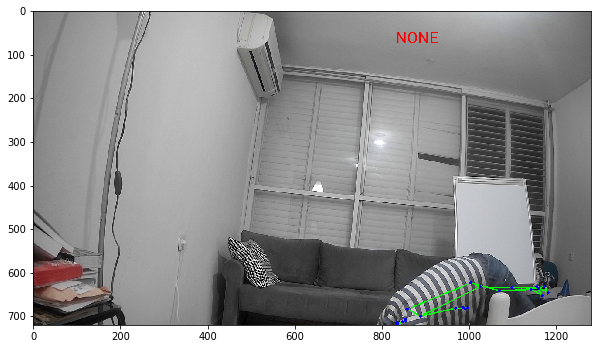

 46%|████▌     | 254/558.0 [00:24<00:39,  7.79it/s]

#######################################################
{'AdhoMukhaSvanasana': 2.9544194371283217, 'UrdhvaMukhaShvanasana': 7.045580562871677}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.4597677493839942, 'UrdhvaMukhaShvanasana': 6.540232250616006}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 3.3196980996665264, 'UrdhvaMukhaShvanasana': 6.680301900333471}
#######################################################


 46%|████▌     | 256/558.0 [00:24<00:34,  8.74it/s]

#######################################################
{'AdhoMukhaSvanasana': 3.007642379892553, 'UrdhvaMukhaShvanasana': 6.9923576201074455}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.7579978040733737, 'UrdhvaMukhaShvanasana': 7.242002195926626}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.5823401933383643, 'UrdhvaMukhaShvanasana': 7.417659806661636}
#######################################################


 47%|████▋     | 260/558.0 [00:25<00:28, 10.33it/s]

#######################################################
{'AdhoMukhaSvanasana': 2.4177560548300234, 'UrdhvaMukhaShvanasana': 7.582243945169976}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.558262893784353, 'UrdhvaMukhaShvanasana': 7.441737106215647}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.670668364947816, 'UrdhvaMukhaShvanasana': 7.329331635052182}
#######################################################


 47%|████▋     | 262/558.0 [00:25<00:27, 10.68it/s]

#######################################################
{'AdhoMukhaSvanasana': 2.736534691958253, 'UrdhvaMukhaShvanasana': 7.263465308041745}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.7892277535666024, 'UrdhvaMukhaShvanasana': 7.210772246433397}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 2.559208053092279, 'UrdhvaMukhaShvanasana': 7.440791946907719}
#######################################################


 48%|████▊     | 266/558.0 [00:25<00:24, 11.74it/s]

#######################################################
{'AdhoMukhaSvanasana': 2.423308392553489, 'UrdhvaMukhaShvanasana': 7.576691607446511}
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 48%|████▊     | 268/558.0 [00:25<00:24, 11.74it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 49%|████▊     | 272/558.0 [00:26<00:24, 11.66it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 49%|████▉     | 274/558.0 [00:26<00:24, 11.56it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 50%|████▉     | 278/558.0 [00:26<00:23, 11.82it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 50%|█████     | 280/558.0 [00:26<00:23, 11.78it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 51%|█████     | 284/558.0 [00:27<00:22, 12.00it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 51%|█████▏    | 286/558.0 [00:27<00:23, 11.81it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 52%|█████▏    | 290/558.0 [00:27<00:22, 12.05it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 52%|█████▏    | 292/558.0 [00:27<00:22, 11.91it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 53%|█████▎    | 296/558.0 [00:28<00:22, 11.89it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 53%|█████▎    | 298/558.0 [00:28<00:22, 11.70it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 54%|█████▍    | 300/558.0 [00:28<00:21, 11.80it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################


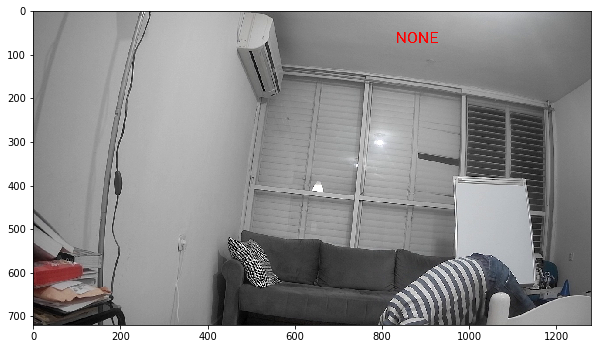

 54%|█████▍    | 304/558.0 [00:29<00:34,  7.44it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 55%|█████▍    | 306/558.0 [00:29<00:30,  8.39it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 56%|█████▌    | 310/558.0 [00:29<00:24,  9.97it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 56%|█████▌    | 312/558.0 [00:29<00:23, 10.28it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 57%|█████▋    | 316/558.0 [00:30<00:22, 10.86it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 57%|█████▋    | 318/558.0 [00:30<00:21, 11.01it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 57%|█████▋    | 320/558.0 [00:30<00:21, 11.22it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 58%|█████▊    | 324/558.0 [00:31<00:20, 11.15it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 59%|█████▉    | 328/558.0 [00:31<00:20, 11.33it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 59%|█████▉    | 330/558.0 [00:31<00:20, 11.35it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 60%|█████▉    | 334/558.0 [00:31<00:19, 11.34it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 60%|██████    | 336/558.0 [00:32<00:19, 11.38it/s]

#######################################################
None
#######################################################
#######################################################
None
#######################################################
#######################################################
None
#######################################################


 61%|██████    | 340/558.0 [00:32<00:19, 11.27it/s]

#######################################################
{'AdhoMukhaSvanasana': 0.2240580499203342, 'UrdhvaMukhaShvanasana': 2.016522449283008}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.40330448985660156, 'UrdhvaMukhaShvanasana': 3.629740408709414}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.5467016418056155, 'UrdhvaMukhaShvanasana': 4.92031477625054}
#######################################################


 61%|██████▏   | 342/558.0 [00:32<00:18, 11.53it/s]

#######################################################
{'AdhoMukhaSvanasana': 0.6614193633648267, 'UrdhvaMukhaShvanasana': 5.95277427028344}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.5291354906918614, 'UrdhvaMukhaShvanasana': 7.002799915430094}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.6473664424738232, 'UrdhvaMukhaShvanasana': 7.618762381627085}
#######################################################


 62%|██████▏   | 346/558.0 [00:32<00:17, 11.91it/s]

#######################################################
{'AdhoMukhaSvanasana': 0.741951203899393, 'UrdhvaMukhaShvanasana': 8.111532354584675}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.8176190130398486, 'UrdhvaMukhaShvanasana': 8.505748332950748}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.8781532603522132, 'UrdhvaMukhaShvanasana': 8.821121115643606}
#######################################################


 62%|██████▏   | 348/558.0 [00:33<00:17, 11.98it/s]

#######################################################
{'AdhoMukhaSvanasana': 0.9265806582021049, 'UrdhvaMukhaShvanasana': 9.073419341797894}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.7172064766413496, 'UrdhvaMukhaShvanasana': 9.282793523358649}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.5497071313927453, 'UrdhvaMukhaShvanasana': 9.450292868607251}
#######################################################


 63%|██████▎   | 350/558.0 [00:33<00:17, 11.64it/s]

#######################################################
{'AdhoMukhaSvanasana': 0.41570765519386205, 'UrdhvaMukhaShvanasana': 9.584292344806135}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.3085080742347554, 'UrdhvaMukhaShvanasana': 9.691491925765243}
#######################################################


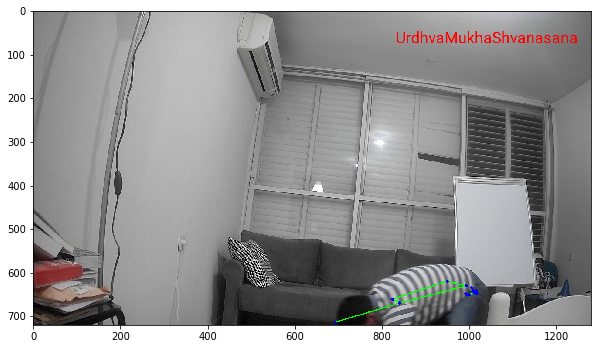

 63%|██████▎   | 354/558.0 [00:34<00:26,  7.64it/s]

#######################################################
{'AdhoMukhaSvanasana': 0.2468064593878043, 'UrdhvaMukhaShvanasana': 9.753193540612195}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.17338711758990918, 'UrdhvaMukhaShvanasana': 9.82661288241009}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.11465164415159307, 'UrdhvaMukhaShvanasana': 9.885348355848405}
#######################################################


 64%|██████▍   | 356/558.0 [00:34<00:23,  8.44it/s]

#######################################################
{'AdhoMukhaSvanasana': 0.06766326540094017, 'UrdhvaMukhaShvanasana': 9.932336734599058}
#######################################################
#######################################################
{'AdhoMukhaSvanasana': 0.030072562400417852, 'UrdhvaMukhaShvanasana': 9.96992743759958}
#######################################################
#######################################################
{'UrdhvaMukhaShvanasana': 9.999999999999998}
#######################################################


 65%|██████▍   | 360/558.0 [00:34<00:19,  9.97it/s]

#######################################################
{'Uttanasana': 0.2240580499203342, 'AdhoMukhaSvanasana': 0.4481160998406684, 'UrdhvaMukhaShvanasana': 9.327825850238996}
#######################################################
#######################################################
{'Uttanasana': 0.40330448985660156, 'AdhoMukhaSvanasana': 1.0306670296335372, 'UrdhvaMukhaShvanasana': 8.56602848050986}
#######################################################
#######################################################
{'Uttanasana': 0.7707596917259497, 'AdhoMukhaSvanasana': 1.2726497235474985, 'UrdhvaMukhaShvanasana': 7.95659058472655}
#######################################################


 65%|██████▍   | 362/558.0 [00:34<00:18, 10.47it/s]

#######################################################
{'Uttanasana': 0.6166077533807598, 'AdhoMukhaSvanasana': 1.242177828758333, 'UrdhvaMukhaShvanasana': 8.141214417860905}
#######################################################
#######################################################
{'Uttanasana': 0.9414023025452762, 'AdhoMukhaSvanasana': 1.2178003129270007, 'UrdhvaMukhaShvanasana': 7.840797384527722}
#######################################################
#######################################################
{'Uttanasana': 0.7531218420362211, 'AdhoMukhaSvanasana': 1.1982983002619347, 'UrdhvaMukhaShvanasana': 8.048579857701844}
#######################################################


 65%|██████▌   | 364/558.0 [00:34<00:17, 10.78it/s]

#######################################################
{'Uttanasana': 0.602497473628977, 'AdhoMukhaSvanasana': 1.182696690129882, 'UrdhvaMukhaShvanasana': 8.214805836241139}
#######################################################
#######################################################
None
#######################################################


 66%|██████▌   | 368/558.0 [00:35<00:17, 10.84it/s]

#######################################################
{'Uttanasana': 0.3855983831225453, 'AdhoMukhaSvanasana': 2.549390281045799, 'UrdhvaMukhaShvanasana': 5.272546936468981}
#######################################################
#######################################################
{'Uttanasana': 0.30847870649803627, 'AdhoMukhaSvanasana': 4.28009272403998, 'UrdhvaMukhaShvanasana': 3.977457049971842}
#######################################################
#######################################################
{'Uttanasana': 0.22272491527809474, 'AdhoMukhaSvanasana': 5.6165385785946595, 'UrdhvaMukhaShvanasana': 3.0135592905351345}
#######################################################


 66%|██████▋   | 370/558.0 [00:35<00:17, 10.98it/s]

#######################################################
{'Uttanasana': 0.15412188230214152, 'AdhoMukhaSvanasana': 6.661637212318066, 'UrdhvaMukhaShvanasana': 2.2664991329061017}
#######################################################
#######################################################
{'Uttanasana': 0.07518140600104463, 'AdhoMukhaSvanasana': 7.521774169217127, 'UrdhvaMukhaShvanasana': 1.668851006802876}
#######################################################
#######################################################
{'Uttanasana': 0.7323192745618383, 'AdhoMukhaSvanasana': 7.561767634895707, 'UrdhvaMukhaShvanasana': 1.1185583561592922}
#######################################################


 67%|██████▋   | 374/558.0 [00:35<00:15, 11.57it/s]

#######################################################
{'Uttanasana': 0.9858554196494705, 'AdhoMukhaSvanasana': 7.593762407438571, 'UrdhvaMukhaShvanasana': 0.9504983854054281}
#######################################################
#######################################################
{'Uttanasana': 1.6849165354009132, 'AdhoMukhaSvanasana': 7.171242125632195, 'UrdhvaMukhaShvanasana': 0.767934308961668}
#######################################################
#######################################################
{'Uttanasana': 1.571991278241065, 'AdhoMukhaSvanasana': 7.0572839501074265, 'UrdhvaMukhaShvanasana': 1.0699991476473285}
#######################################################


 67%|██████▋   | 376/558.0 [00:35<00:15, 11.56it/s]

#######################################################
{'Uttanasana': 2.1538252222741887, 'AdhoMukhaSvanasana': 6.318001309846944, 'UrdhvaMukhaShvanasana': 1.5281734678788657}
#######################################################
#######################################################
{'Uttanasana': 2.619292377500688, 'AdhoMukhaSvanasana': 5.534110798275885, 'UrdhvaMukhaShvanasana': 1.8465968242234263}
#######################################################
#######################################################
{'Uttanasana': 3.2157241516022212, 'Tadasana': 0.2240580499203342, 'AdhoMukhaSvanasana': 4.186708139417365, 'UrdhvaMukhaShvanasana': 2.3735096590600784}
#######################################################


 68%|██████▊   | 380/558.0 [00:36<00:15, 11.84it/s]

#######################################################
{'Uttanasana': 3.468811520963114, 'Tadasana': 0.6273625397769358, 'AdhoMukhaSvanasana': 3.1087860123305493, 'UrdhvaMukhaShvanasana': 2.7950399269293995}
#######################################################
#######################################################
{'Uttanasana': 3.447223366531494, 'Tadasana': 1.6221802814232198, 'AdhoMukhaSvanasana': 2.246448310661097, 'UrdhvaMukhaShvanasana': 2.684148041384188}
#######################################################
#######################################################
{'Uttanasana': 3.6540108929065327, 'Tadasana': 2.1939764248199127, 'AdhoMukhaSvanasana': 1.5565781493255344, 'UrdhvaMukhaShvanasana': 2.5954345329480186}
#######################################################


 68%|██████▊   | 382/558.0 [00:36<00:14, 11.78it/s]

#######################################################
{'Uttanasana': 3.0750926144845576, 'Tadasana': 3.0995294393779353, 'AdhoMukhaSvanasana': 1.0768561700180876, 'UrdhvaMukhaShvanasana': 2.7485217761194183}
#######################################################
#######################################################
{'Uttanasana': 2.636016041667312, 'Tadasana': 4.496146000785356, 'AdhoMukhaSvanasana': 0.6930785865721302, 'UrdhvaMukhaShvanasana': 2.1747593709752007}
#######################################################
#######################################################
{'Uttanasana': 2.0125806336525125, 'Tadasana': 5.613439249911294, 'AdhoMukhaSvanasana': 0.43417261965603277, 'UrdhvaMukhaShvanasana': 1.9398074967801604}
#######################################################


 69%|██████▉   | 386/558.0 [00:36<00:14, 11.93it/s]

#######################################################
{'Uttanasana': 1.5860064570016759, 'Tadasana': 6.507273849212043, 'AdhoMukhaSvanasana': 0.2029897962028205, 'UrdhvaMukhaShvanasana': 1.7037298975834598}
#######################################################
#######################################################
{'Uttanasana': 1.1725729659200035, 'Tadasana': 7.222341528652641, 'AdhoMukhaSvanasana': 0.09021768720125355, 'UrdhvaMukhaShvanasana': 1.5148678182260993}
#######################################################
#######################################################
{'Uttanasana': 0.8418261730546657, 'Tadasana': 7.7943956722051215, 'UrdhvaMukhaShvanasana': 1.363778154740211}
#######################################################


 70%|██████▉   | 388/558.0 [00:36<00:14, 11.72it/s]

#######################################################
{'Uttanasana': 0.5531706888420611, 'Tadasana': 8.227980937126771, 'UrdhvaMukhaShvanasana': 1.2188483740311657}
#######################################################
#######################################################
{'Uttanasana': 0.3463043513923118, 'Tadasana': 8.550791099143758, 'UrdhvaMukhaShvanasana': 1.1029045494639298}
#######################################################
#######################################################
{'Vrikshasana': 0.2240580499203342, 'Uttanasana': 0.20486933135284663, 'Tadasana': 8.736865078996342, 'UrdhvaMukhaShvanasana': 0.8342075397304752}
#######################################################


 70%|███████   | 392/558.0 [00:37<00:14, 11.53it/s]

#######################################################
{'Vrikshasana': 0.17924643993626738, 'Uttanasana': 0.06766326540094017, 'Tadasana': 8.909782312798747, 'UrdhvaMukhaShvanasana': 0.8433079818640459}
#######################################################
#######################################################
{'Vrikshasana': 0.14339715194901392, 'Uttanasana': 0.030072562400417852, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.8265302856505682}
#######################################################
#######################################################
{'Vrikshasana': 0.11471772155921114, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.8852822784407888}
#######################################################


 71%|███████   | 394/558.0 [00:37<00:14, 11.15it/s]

#######################################################
{'Vrikshasana': 0.09177417724736892, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.9082258227526311}
#######################################################
#######################################################
{'Vrikshasana': 0.29747739171822934, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.7025226082817706}
#######################################################
#######################################################
{'Vrikshasana': 0.46203996329491764, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.5379600367050822}
#######################################################


 71%|███████▏  | 398/558.0 [00:37<00:14, 11.21it/s]

#######################################################
{'Vrikshasana': 0.5936900205562685, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.40630997944373154}
#######################################################
#######################################################
{'Vrikshasana': 0.699010066365349, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.30098993363465093}
#######################################################
#######################################################
{'Vrikshasana': 0.7832661030126135, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.21673389698738646}
#######################################################


 72%|███████▏  | 400/558.0 [00:38<00:14, 11.13it/s]

#######################################################
{'Vrikshasana': 0.8266128824100907, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.17338711758990918}
#######################################################
#######################################################
{'Vrikshasana': 0.8853483558484069, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.11465164415159307}
#######################################################
#######################################################
{'Vrikshasana': 0.9323367345990597, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.06766326540094017}
#######################################################


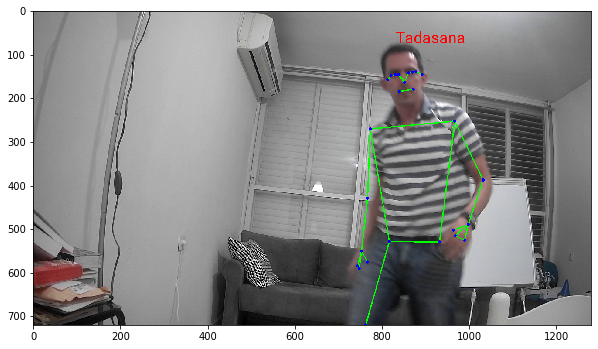

 72%|███████▏  | 403/558.0 [00:38<00:24,  6.41it/s]

#######################################################
{'Vrikshasana': 0.9699274375995821, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.030072562400417852}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 73%|███████▎  | 406/558.0 [00:39<00:18,  8.15it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 73%|███████▎  | 408/558.0 [00:39<00:16,  9.02it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 74%|███████▍  | 412/558.0 [00:39<00:14, 10.22it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 74%|███████▍  | 414/558.0 [00:39<00:13, 10.49it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 75%|███████▍  | 418/558.0 [00:40<00:12, 11.09it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 75%|███████▌  | 420/558.0 [00:40<00:12, 11.10it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 76%|███████▌  | 424/558.0 [00:40<00:11, 11.47it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 76%|███████▋  | 426/558.0 [00:40<00:11, 11.35it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 77%|███████▋  | 430/558.0 [00:41<00:11, 11.32it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################


 77%|███████▋  | 432/558.0 [00:41<00:11, 11.17it/s]

#######################################################
{'Vrikshasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.7759419500796657, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.2240580499203342}
#######################################################
#######################################################
{'Vrikshasana': 0.8207535600637325, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.17924643993626738}
#######################################################


 78%|███████▊  | 436/558.0 [00:41<00:10, 11.44it/s]

#######################################################
{'Vrikshasana': 0.856602848050986, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.14339715194901392}
#######################################################
#######################################################
{'Vrikshasana': 0.8852822784407888, 'Tadasana': 8.999999999999998, 'UrdhvaMukhaShvanasana': 0.11471772155921114}
#######################################################
#######################################################
{'UrdhvaMukhaShvanasana': 0.09177417724736892, 'Vrikshasana': 0.6841677728322968, 'Trikonasana': 0.2240580499203342, 'Tadasana': 8.999999999999998}
#######################################################


 78%|███████▊  | 438/558.0 [00:41<00:10, 11.29it/s]

#######################################################
{'Vrikshasana': 0.7473342182658373, 'Tadasana': 8.999999999999998, 'Trikonasana': 0.17924643993626738, 'UrdhvaMukhaShvanasana': 0.07341934179789514}
#######################################################
#######################################################
{'Vrikshasana': 0.5738093246923357, 'Trikonasana': 0.14339715194901392, 'UrdhvaMukhaShvanasana': 0.058735473438316116, 'Uttanasana': 0.2240580499203342, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.6590474597538685, 'Trikonasana': 0.11471772155921114, 'UrdhvaMukhaShvanasana': 0.0469883787506529, 'Uttanasana': 0.17924643993626738, 'Tadasana': 8.999999999999998}
#######################################################


 79%|███████▉  | 442/558.0 [00:42<00:10, 11.42it/s]

#######################################################
{'Vrikshasana': 0.5031799178827605, 'Trikonasana': 0.09177417724736892, 'UrdhvaMukhaShvanasana': 0.037590703000522314, 'Uttanasana': 0.3674552018693481, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.3784858843858742, 'Trikonasana': 0.07341934179789514, 'UrdhvaMukhaShvanasana': 0.030072562400417852, 'Uttanasana': 0.5180222114158127, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.30278870750869935, 'Uttanasana': 0.6384758190529845, 'Tadasana': 8.999999999999998, 'Trikonasana': 0.058735473438316116}
#######################################################


 80%|███████▉  | 444/558.0 [00:42<00:10, 11.01it/s]

#######################################################
{'Vrikshasana': 0.2181729160866252, 'Uttanasana': 0.7348387051627218, 'Tadasana': 8.999999999999998, 'Trikonasana': 0.0469883787506529}
#######################################################
#######################################################
{'Vrikshasana': 0.1504802829489659, 'Uttanasana': 0.8119290140505118, 'Tadasana': 8.999999999999998, 'Trikonasana': 0.037590703000522314}
#######################################################
#######################################################
{'Vrikshasana': 0.09632617643883844, 'Uttanasana': 0.8736012611607437, 'Tadasana': 8.999999999999998, 'Trikonasana': 0.030072562400417852}
#######################################################


 80%|████████  | 448/558.0 [00:42<00:09, 11.69it/s]

#######################################################
{'Vrikshasana': 0.07706094115107076, 'Uttanasana': 0.922939058848929, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.037590703000522314, 'Uttanasana': 0.9624092969994776, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.030072562400417852, 'Uttanasana': 0.9699274375995821, 'Tadasana': 8.999999999999998}
#######################################################


 81%|████████  | 450/558.0 [00:43<00:09, 11.42it/s]

#######################################################
{'Uttanasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Uttanasana': 1.0, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.2240580499203342, 'Uttanasana': 0.7759419500796657, 'Tadasana': 8.999999999999998}
#######################################################


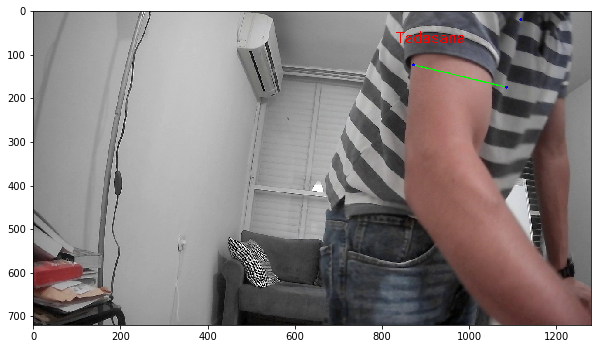

 81%|████████  | 453/558.0 [00:43<00:15,  6.61it/s]

#######################################################
{'Vrikshasana': 0.40330448985660156, 'Uttanasana': 0.5966955101433983, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.5467016418056155, 'Uttanasana': 0.45329835819438435, 'Tadasana': 8.999999999999998}
#######################################################
#######################################################
{'Vrikshasana': 0.8854774132851608, 'Uttanasana': 0.3385806366351733, 'Tadasana': 8.775941950079664}


 82%|████████▏ | 455/558.0 [00:43<00:13,  7.77it/s]

#######################################################
#######################################################
{'Vrikshasana': 1.3805560803891315, 'Uttanasana': 0.2468064593878043, 'Tadasana': 8.372637460223064}
#######################################################
#######################################################
{'Vrikshasana': 1.776619014072308, 'Uttanasana': 0.17338711758990918, 'Tadasana': 8.049993868337781}
#######################################################


 82%|████████▏ | 459/558.0 [00:44<00:10,  9.52it/s]

#######################################################
{'Vrikshasana': 3.661875710461188, 'Uttanasana': 0.11465164415159307, 'Tadasana': 6.223472645387218}
#######################################################
#######################################################
{'Vrikshasana': 4.273848867890956, 'Uttanasana': 0.06766326540094017, 'Tadasana': 5.658487866708103}
#######################################################
#######################################################
{'Vrikshasana': 5.659659593516108, 'Uttanasana': 0.030072562400417852, 'Tadasana': 4.310267844083473}
#######################################################


 83%|████████▎ | 461/558.0 [00:44<00:09,  9.85it/s]

#######################################################
{'Vrikshasana': 6.7683081740162265, 'Tadasana': 3.231691825983771}
#######################################################
#######################################################
{'Vrikshasana': 7.631168988495991, 'Tadasana': 2.368831011504008}
#######################################################
#######################################################
{'Vrikshasana': 7.873341540239132, 'Tadasana': 2.126658459760866}
#######################################################


 83%|████████▎ | 465/558.0 [00:44<00:08, 10.93it/s]

#######################################################
{'Vrikshasana': 8.29113763155398, 'Tadasana': 1.708862368446019}
#######################################################
#######################################################
{'Vrikshasana': 8.153200354844856, 'Tadasana': 1.8467996451551434}
#######################################################
#######################################################
{'Vrikshasana': 8.690966633318222, 'Tadasana': 1.3090333666817748}
#######################################################


 84%|████████▎ | 467/558.0 [00:45<00:08, 11.04it/s]

#######################################################
{'Vrikshasana': 9.121179656096919, 'Tadasana': 0.87882034390308}
#######################################################
#######################################################
{'Vrikshasana': 7.504479325514862, 'Tadasana': 2.4955206744851375}
#######################################################
#######################################################
{'Vrikshasana': 7.427641510332222, 'Tadasana': 2.5723584896677756}
#######################################################


 84%|████████▍ | 471/558.0 [00:45<00:07, 11.45it/s]

#######################################################
{'Vrikshasana': 7.718055158345444, 'Tadasana': 2.2819448416545547}
#######################################################
#######################################################
{'Vrikshasana': 7.726328026835686, 'Tadasana': 2.2736719731643125}
#######################################################
#######################################################
{'Vrikshasana': 6.836714121946542, 'Tadasana': 3.163285878053456}
#######################################################


 85%|████████▍ | 473/558.0 [00:45<00:07, 11.34it/s]

#######################################################
{'Vrikshasana': 6.6212551977165655, 'Tadasana': 3.378744802283433}
#######################################################
#######################################################
{'Vrikshasana': 5.976713908571582, 'Tadasana': 4.023286091428417}
#######################################################
#######################################################
{'Vrikshasana': 5.733255027016596, 'Tadasana': 4.266744972983402}
#######################################################


 85%|████████▌ | 477/558.0 [00:45<00:06, 11.80it/s]

#######################################################
{'Vrikshasana': 5.914429871852274, 'Tadasana': 4.085570128147725}
#######################################################
#######################################################
{'Vrikshasana': 6.731543897481818, 'Tadasana': 3.26845610251818}
#######################################################
#######################################################
{'Vrikshasana': 7.353641467427794, 'Tadasana': 2.4223004826518695, 'VirabhadrasanaI': 0.2240580499203342}
#######################################################


 86%|████████▌ | 479/558.0 [00:46<00:07, 10.14it/s]

#######################################################
{'Vrikshasana': 7.506971223862568, 'Tadasana': 2.3137823362011614, 'VirabhadrasanaI': 0.17924643993626738}
#######################################################
#######################################################
{'Vrikshasana': 7.133402829329054, 'Tadasana': 2.7232000187219323, 'VirabhadrasanaI': 0.14339715194901392}
#######################################################


 86%|████████▌ | 481/558.0 [00:46<00:07, 10.47it/s]

#######################################################
{'Vrikshasana': 5.9623739639412365, 'Tadasana': 3.9229083144995505, 'VirabhadrasanaI': 0.11471772155921114}
#######################################################
#######################################################
{'Vrikshasana': 6.9142474706749955, 'Tadasana': 2.993978352077635, 'VirabhadrasanaI': 0.09177417724736892}
#######################################################
#######################################################
{'Vrikshasana': 5.611107726938324, 'Tadasana': 4.315472931263779, 'VirabhadrasanaI': 0.07341934179789514}
#######################################################


 87%|████████▋ | 485/558.0 [00:46<00:06, 11.03it/s]

#######################################################
{'Vrikshasana': 6.633234481072665, 'Tadasana': 3.308030045489018, 'VirabhadrasanaI': 0.058735473438316116}
#######################################################
#######################################################
{'Vrikshasana': 5.634413435097128, 'Tadasana': 4.318598186152217, 'VirabhadrasanaI': 0.0469883787506529}
#######################################################
#######################################################
{'Vrikshasana': 4.787240498476033, 'Tadasana': 5.175168798523444, 'VirabhadrasanaI': 0.037590703000522314}
#######################################################


 87%|████████▋ | 487/558.0 [00:46<00:06, 11.07it/s]

#######################################################
{'Vrikshasana': 5.829792398780826, 'Tadasana': 4.140135038818755, 'VirabhadrasanaI': 0.030072562400417852}
#######################################################
#######################################################
{'Vrikshasana': 6.687891968944993, 'Tadasana': 3.312108031055005}
#######################################################
#######################################################
{'Vrikshasana': 6.054081375474658, 'Tadasana': 3.945918624525341}
#######################################################


 88%|████████▊ | 491/558.0 [00:47<00:05, 11.40it/s]

#######################################################
{'Vrikshasana': 6.939497300061063, 'Tadasana': 3.060502699938936}
#######################################################
#######################################################
{'Vrikshasana': 6.623771989809852, 'Tadasana': 3.376228010190146}
#######################################################
#######################################################
{'Vrikshasana': 7.299017591847883, 'Tadasana': 2.7009824081521163}
#######################################################


 88%|████████▊ | 493/558.0 [00:47<00:05, 11.19it/s]

#######################################################
{'Vrikshasana': 8.055736522761315, 'Tadasana': 1.9442634772386849}
#######################################################
#######################################################
{'Vrikshasana': 8.44458921820905, 'Tadasana': 1.555410781790948}
#######################################################
#######################################################
{'Vrikshasana': 8.948135773929913, 'Tadasana': 1.0518642260700841}
#######################################################


 89%|████████▊ | 495/558.0 [00:47<00:05, 11.51it/s]

#######################################################
{'Vrikshasana': 9.350973018506604, 'Tadasana': 0.6490269814933931}
#######################################################
#######################################################
{'Vrikshasana': 9.480778414805286, 'Tadasana': 0.5192215851947144}
#######################################################
#######################################################
{'Vrikshasana': 9.584622731844227, 'Tadasana': 0.4153772681557716}
#######################################################


 89%|████████▉ | 499/558.0 [00:47<00:05, 11.48it/s]

#######################################################
{'Vrikshasana': 8.243640135555047, 'Tadasana': 1.7563598644449512}
#######################################################
#######################################################
{'Vrikshasana': 8.594912108444037, 'Tadasana': 1.405087891555961}
#######################################################
#######################################################
{'Vrikshasana': 8.996219936356901, 'Tadasana': 1.0037800636430974}
#######################################################
#######################################################
{'Vrikshasana': 9.19697594908552, 'Tadasana': 0.803024050914478}
#######################################################


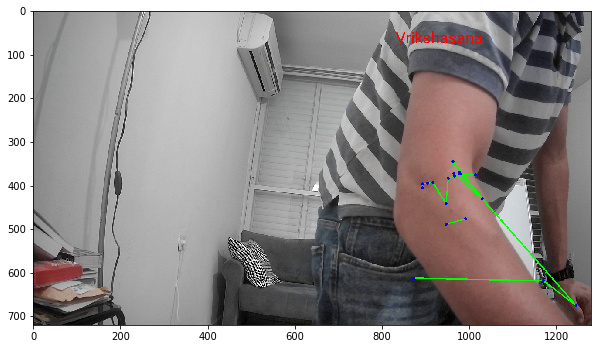

 90%|█████████ | 503/558.0 [00:48<00:07,  7.08it/s]

#######################################################
{'Vrikshasana': 9.357580759268416, 'Tadasana': 0.6424192407315824}
#######################################################
#######################################################
{'Vrikshasana': 9.486064607414733, 'Tadasana': 0.513935392585266}
#######################################################


 91%|█████████ | 506/558.0 [00:48<00:05,  8.79it/s]

#######################################################
{'Vrikshasana': 9.588851685931786, 'Tadasana': 0.4111483140682128}
#######################################################
#######################################################
{'Vrikshasana': 7.878616949382754, 'Tadasana': 2.121383050617244}
#######################################################
#######################################################
{'Vrikshasana': 8.302893559506204, 'Tadasana': 1.6971064404937952}
#######################################################


 91%|█████████ | 508/558.0 [00:49<00:05,  9.62it/s]

#######################################################
{'Vrikshasana': 6.625792398321955, 'Tadasana': 3.374207601678044}
#######################################################
#######################################################
{'Vrikshasana': 7.020924168259235, 'Tadasana': 2.9790758317407633}
#######################################################
#######################################################
{'Vrikshasana': 7.616739334607386, 'Tadasana': 2.3832606653926116}
#######################################################


 92%|█████████▏| 512/558.0 [00:49<00:04, 10.64it/s]

#######################################################
{'Vrikshasana': 8.093391467685908, 'Tadasana': 1.9066085323140893}
#######################################################
#######################################################
{'Vrikshasana': 8.474713174148725, 'Tadasana': 1.5252868258512717}
#######################################################
#######################################################
{'Vrikshasana': 8.779770539318982, 'Tadasana': 1.2202294606810173}
#######################################################


 92%|█████████▏| 514/558.0 [00:49<00:04, 10.50it/s]

#######################################################
{'Vrikshasana': 9.023816431455185, 'Tadasana': 0.9761835685448138}
#######################################################
#######################################################
{'Vrikshasana': 8.994995095243812, 'Tadasana': 0.7809468548358511, 'VirabhadrasanaI': 0.2240580499203342}
#######################################################
#######################################################
{'Vrikshasana': 9.16440242563739, 'Tadasana': 0.4322930845060067, 'VirabhadrasanaI': 0.40330448985660156}
#######################################################


 93%|█████████▎| 518/558.0 [00:50<00:03, 11.06it/s]

#######################################################
{'Vrikshasana': 9.107463890589578, 'Tadasana': 0.3458344676048053, 'VirabhadrasanaI': 0.5467016418056155}
#######################################################
#######################################################
{'Vrikshasana': 9.054377461914001, 'Tadasana': 0.5082612246415041, 'VirabhadrasanaI': 0.43736131344449247}
#######################################################
#######################################################
{'Vrikshasana': 9.291618069371868, 'Tadasana': 0.35849287987253475, 'VirabhadrasanaI': 0.34988905075559396}
#######################################################


 93%|█████████▎| 520/558.0 [00:50<00:03, 10.85it/s]

#######################################################
{'Vrikshasana': 7.640830056134822, 'Tadasana': 2.0792587032607015, 'VirabhadrasanaI': 0.2799112406044752}
#######################################################
#######################################################
{'Vrikshasana': 6.09614159562485, 'Tadasana': 3.679929411891569, 'VirabhadrasanaI': 0.22392899248358017}
#######################################################
#######################################################
{'Vrikshasana': 6.876913276499879, 'Tadasana': 2.9439435295132554, 'VirabhadrasanaI': 0.17914319398686415}
#######################################################


 94%|█████████▍| 524/558.0 [00:50<00:02, 11.35it/s]

#######################################################
{'Vrikshasana': 5.485008171916894, 'Tadasana': 4.371677272893613, 'VirabhadrasanaI': 0.14331455518949132}
#######################################################
#######################################################
{'Vrikshasana': 6.388006537533515, 'Tadasana': 3.4973418183148905, 'VirabhadrasanaI': 0.11465164415159307}
#######################################################
#######################################################
{'Vrikshasana': 6.23823108026581, 'Tadasana': 3.6941056543332493, 'VirabhadrasanaI': 0.06766326540094017}
#######################################################


 94%|█████████▍| 526/558.0 [00:50<00:02, 11.10it/s]

#######################################################
{'Vrikshasana': 6.342468764371979, 'Tadasana': 3.627458673227602, 'VirabhadrasanaI': 0.030072562400417852}
#######################################################
#######################################################
{'Vrikshasana': 6.873975011497582, 'Tadasana': 2.9019669385820817, 'VirabhadrasanaI': 0.2240580499203342}
#######################################################
#######################################################
{'Vrikshasana': 7.547296109038734, 'Tadasana': 2.2734574510249974, 'VirabhadrasanaI': 0.17924643993626738}
#######################################################


 95%|█████████▍| 530/558.0 [00:51<00:02, 11.21it/s]

#######################################################
{'Vrikshasana': 8.037836887230986, 'Tadasana': 1.8187659608199978, 'VirabhadrasanaI': 0.14339715194901392}
#######################################################
#######################################################
{'Vrikshasana': 8.622733909147463, 'Tadasana': 1.2625483692933241, 'VirabhadrasanaI': 0.11471772155921114}
#######################################################
#######################################################
{'Vrikshasana': 9.114709576600978, 'Tadasana': 0.7935162461516506, 'VirabhadrasanaI': 0.09177417724736892}
#######################################################


 95%|█████████▌| 532/558.0 [00:51<00:02, 10.70it/s]

#######################################################
{'Vrikshasana': 7.499303261918111, 'Tadasana': 2.427277396283994, 'VirabhadrasanaI': 0.07341934179789514}
#######################################################
#######################################################
{'Vrikshasana': 8.215965058817494, 'Tadasana': 1.725299467744187, 'VirabhadrasanaI': 0.058735473438316116}
#######################################################
#######################################################
{'Vrikshasana': 8.572772047053997, 'Tadasana': 1.3802395741953497, 'VirabhadrasanaI': 0.0469883787506529}
#######################################################


 96%|█████████▌| 536/558.0 [00:51<00:01, 11.26it/s]

#######################################################
{'Vrikshasana': 7.834159587722862, 'Tadasana': 2.1282497092766133, 'VirabhadrasanaI': 0.037590703000522314}
#######################################################
#######################################################
{'Vrikshasana': 8.339501819939292, 'Tadasana': 1.6304256176602883, 'VirabhadrasanaI': 0.030072562400417852}
#######################################################
#######################################################
{'Vrikshasana': 8.695659505871769, 'Tadasana': 1.3043404941282308}
#######################################################


 96%|█████████▋| 538/558.0 [00:51<00:01, 10.97it/s]

#######################################################
{'Vrikshasana': 7.16406320533474, 'Tadasana': 2.8359367946652583}
#######################################################
#######################################################
{'Vrikshasana': 7.507192514347457, 'Tadasana': 2.492807485652541}
#######################################################
#######################################################
{'Vrikshasana': 5.9892315621949574, 'Tadasana': 4.010768437805041}
#######################################################


 97%|█████████▋| 542/558.0 [00:52<00:01, 11.36it/s]

#######################################################
{'Vrikshasana': 6.791385249755966, 'Tadasana': 3.2086147502440325}
#######################################################
#######################################################
{'Vrikshasana': 7.625572599167446, 'Tadasana': 2.3744274008325528}
#######################################################
#######################################################
{'Vrikshasana': 8.100458079333958, 'Tadasana': 1.8995419206660422}
#######################################################


 97%|█████████▋| 544/558.0 [00:52<00:01, 11.24it/s]

#######################################################
{'Vrikshasana': 8.480366463467165, 'Tadasana': 1.519633536532834}
#######################################################
#######################################################
{'Vrikshasana': 8.68052537045507, 'Tadasana': 1.0954165796245954, 'VirabhadrasanaI': 0.2240580499203342}
#######################################################
#######################################################
{'Vrikshasana': 8.944420296364054, 'Tadasana': 0.8763332636996765, 'VirabhadrasanaI': 0.17924643993626738}
#######################################################


 98%|█████████▊| 548/558.0 [00:52<00:00, 11.63it/s]

#######################################################
{'Vrikshasana': 9.155536237091242, 'Tadasana': 0.7010666109597412, 'VirabhadrasanaI': 0.14339715194901392}
#######################################################
#######################################################
{'Vrikshasana': 7.500370939752661, 'Tadasana': 2.3849113386881267, 'VirabhadrasanaI': 0.11471772155921114}
#######################################################
#######################################################
{'Vrikshasana': 8.024354801722463, 'Tadasana': 1.883871021030167, 'VirabhadrasanaI': 0.09177417724736892}
#######################################################


 99%|█████████▊| 550/558.0 [00:52<00:00, 11.00it/s]

#######################################################
{'Vrikshasana': 8.636006290660978, 'Tadasana': 1.2905743675411254, 'VirabhadrasanaI': 0.07341934179789514}
#######################################################
#######################################################
{'Vrikshasana': 7.116340633166109, 'Tadasana': 2.8249238933955736, 'VirabhadrasanaI': 0.058735473438316116}
#######################################################
#######################################################
{'Vrikshasana': 7.020898356771884, 'Tadasana': 2.932113264477462, 'VirabhadrasanaI': 0.0469883787506529}
#######################################################


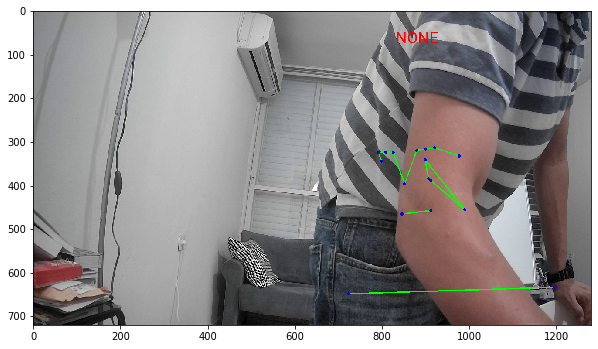

 99%|█████████▉| 553/558.0 [00:53<00:00,  6.47it/s]

#######################################################
{'Vrikshasana': 7.616718685417506, 'Tadasana': 2.34569061158197, 'VirabhadrasanaI': 0.037590703000522314}
#######################################################
#######################################################
{'Vrikshasana': 7.645258848493335, 'Tadasana': 2.324668589106244, 'VirabhadrasanaI': 0.030072562400417852}
#######################################################


100%|█████████▉| 556/558.0 [00:53<00:00,  8.20it/s]

#######################################################
{'Vrikshasana': 8.140265128715003, 'Tadasana': 1.8597348712849955}
#######################################################
#######################################################
{'Vrikshasana': 8.288154053051668, 'Tadasana': 1.4877878970279967, 'VirabhadrasanaI': 0.2240580499203342}
#######################################################
#######################################################
{'Vrikshasana': 8.630523242441333, 'Tadasana': 1.1902303176223972, 'VirabhadrasanaI': 0.17924643993626738}
#######################################################


100%|██████████| 558/558.0 [00:54<00:00, 10.30it/s]


#######################################################
{'Vrikshasana': 9.120941043236076, 'Tadasana': 0.7356618048149093, 'VirabhadrasanaI': 0.14339715194901392}
#######################################################
#######################################################
{'Vrikshasana': 9.29675283458886, 'Tadasana': 0.5885294438519275, 'VirabhadrasanaI': 0.11471772155921114}
#######################################################


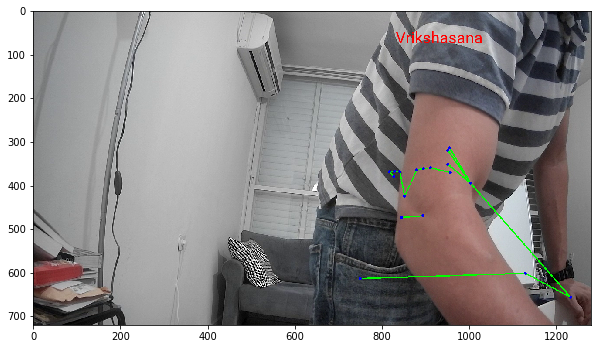

CPU times: user 55.2 s, sys: 1.41 s, total: 56.6 s
Wall time: 54.7 s


In [ ]:
%%time
import time
# Run classification on a video.
import os
import tqdm
from mediapipe.python.solutions import drawing_utils as mp_drawing
start = time.time()

# Open output video.
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 10000
output_frame = None
with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
  while True:
    # Get next frame of the video.
    success, input_frame = video_cap.read()
    if not success:
      break

    # Run pose tracker.
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    result = pose_tracker.process(image=input_frame)
    pose_landmarks = result.pose_landmarks

    # Draw pose prediction.
    output_frame = input_frame.copy()
    if pose_landmarks is not None:
      mp_drawing.draw_landmarks(
          image=output_frame,
          landmark_list=pose_landmarks,
          connections=mp_pose.POSE_CONNECTIONS)
    
    if pose_landmarks is not None:
      # Get landmarks.
      frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
      pose_landmarks = np.array([[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                                 for lmk in pose_landmarks.landmark], dtype=np.float32)
      assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

      # Classify the pose on the current frame.
      pose_classification = pose_classifier(pose_landmarks)

      # Smooth classification using EMA.
      pose_classification_filtered = pose_classification_filter(pose_classification)

      # Count repetitions.
      #repetitions_count = repetition_counter(pose_classification_filtered)
    else:
      # No pose => no classification on current frame.
      pose_classification = None

      # Still add empty classification to the filter to maintaing correct
      # smoothing for future frames.
      pose_classification_filtered = pose_classification_filter(dict())
      pose_classification_filtered = None

      # Don't update the counter presuming that person is 'frozen'. Just
      # take the latest repetitions count.
      repetitions_count = repetition_counter.n_repeats

    # Draw classification plot and repetition counter.
    print("#"*55)
    print(pose_classification_filtered)
    print("#"*55)
    in_asana = "NONE"
    if pose_classification_filtered:
      for k in pose_classification_filtered.keys():
        if pose_classification_filtered[k] > 7.2:
          in_asana = k
    output_frame = pose_classification_visualizer(
        frame=output_frame,
        pose_classification=pose_classification,
        pose_classification_filtered=pose_classification_filtered,
        asana=in_asana)
    # output_frame ? 
    # Save the output frame.
    out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

    # Show intermediate frames of the video to track progress.
    if frame_idx % 50 == 0:
      show_image(output_frame)

    frame_idx += 1
    pbar.update()

# Close output video.
out_video.release()

# Release MediaPipe resources.
pose_tracker.close()

# Show the last frame of the video.
if output_frame is not None:
  show_image(output_frame)

In [ ]:
print("total time is %0.2f"%(time.time() - start))

total time is 3581.15


In [ ]:
# Download generated video
files.download(out_video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(out_video_path)
os.listdir(".")

Seq1Iyengar-out.mov


['.config',
 'fitness_poses_csvs_out',
 'fitness_poses_images_in',
 'TrimSeq.mov',
 'fitness_poses_images_out',
 'fitness_poses_csvs_out.csv',
 'Seq1Iyengar-out.mov',
 'fitness_poses_images_in.zip',
 'sample_data']